## Analysis of flat10MIP output

In [1]:
import numpy as np
import numpy.matlib
import numpy.ma as ma

import xarray as xr
xr.set_options(enable_cftimeindex=True)

import time
import cftime
import netCDF4 as nc
from datetime import timedelta

import pandas as pd

#import xcdat

import matplotlib as mpl
import matplotlib.pyplot as plt

#import cartopy.crs as ccrs
#from cartopy.util import add_cyclic_point

import glob


## notes on packages to add to this kernel
import nc_time_axis
import cartopy.crs as ccrs
import cartopy

/glade/u/apps/opt/conda/envs/npl-2023b/lib/python3.10/site-packages/xarray/core/options.py:115: FutureWarning: The enable_cftimeindex option is now a no-op and will be removed in a future version of xarray.
  warnings.warn(


### Data location

Data downloaded for nird.sigma2.no to /glade/campaign/cgd/tss/people/aswann/flat10/

#### Models
Models with output:  
ACCESS-ESM1-5  
CESM2  
CNRM-ESM2-1  
GFDL-ESM4  
GISS_E2.1  
NorESM2-LM  
MPI-ESM1-2-LR 

Directory structures within each model folder vary - need to account for this 

#### Experiments
flat10: 200 years at 10Pg/yr  
flat10_zec: branches from flat10 at 100 years, zero emissions for 200 years  
flat10_cdr: branches from flat10 at 100 years, ramps down to negative 10 Pg/yr over 100 years, continues at zero emissions for 100 years (until 200 years past flat10)

Total length of each simulation on its own: 200 years

#### Time indexing
Each model did it's time indexing in a different way. Need to account for all of the different calendars.

#### Missing files
The catalog of all CMIP files on glade is at:  
catalog_file = '/glade/collections/cmip/catalog/intake-esm-datastore/catalogs/glade-cmip6.csv.gz'

GISS is missing the land fraction data (sftlf) and cell area data (areacella, areacello)
I tried to find matching grid files on NCAR, but none of the GISS models matched in resolution
Ended up downloading grid files from PCMDI

In [54]:
outputdir= '/glade/campaign/cgd/tss/people/aswann/flat10/'

modellist_orig= ['ACCESS-ESM1-5',  
            'CESM2',    
            'GFDL-ESM4',  
            'GISS_E2.1',  
            'NorESM2-LM',
            'MPI-ESM1-2-LR',
            'CNRM-ESM2-1',
            'HadCM3LC-Bris']
modellist=modellist_orig

runlist = ['flat10','flat10_zec','flat10_cdr']
# use a wildcard to capture different ways the folders and runs are named across models
runlist_wc = ['*lat10','*zec','*cdr']

varlist_load=['cVeg','cSoil','cLitter','nbp','gpp','rh'] #, 'gpp','fgco2', 'ra', 'rh']#, 'npp'] # not working beyond nbp for norESM
varlist_analyze=['cVeg','cSoil','cTot','cLitter','nbp','gpp','rh']
varlist=varlist_load
unitslist=['kgC m-2','kgC m-2','kgC m-2','kgC m-2 s-1','kgC m-2 s-1','kgC m-2 s-1']

# there seems to be a problem with ra for NorESM

modelcolors=['tab:blue','tab:orange','tab:green','tab:red','tab:gray','tab:purple','tab:cyan','gold']
### from ben: colors=["tab:cyan","tab:olive","tab:green","tab:red","tab:gray","tab:pink","limegreen","tab:brown", "slateblue","gold"]

In [3]:
#unitconversions
sperday=60*60*24
speryr=60*60*24*365

PgperKg = 1e-12
# to convert kg m-2 s-1 to kg/m2/yr multiply by speryr

# Lo

In [4]:
# initialize a dictionary to hold all of the data
data_dict={}

In [5]:
# other info that I don't think is necessary - delete later

# python dislikes filenames with dashes
modellist_safe = ['ACCESS',
                  'CESM2',
                  'CNRM',
                  'GFDL',
                  'GISS',
                  'NorESM2']

caltype = ['DatetimeProlepticGregorian',
           'DatetimeNoLeap',
           'DatetimeGregorian',
           'DatetimeNoLeap',
           'year',
           'DatetimeNoLeap']

startdate = [101, 1, 1850, 1, 1850, 1850]


### Define Functions

In [6]:
def weighted_temporal_mean(ds, var):
    """
    takes an annual average weighted by days in each month

    Args:
    - dataset: xarray dataset with monthly resolution data
    - var: variable name to be averaged

    Returns:
    - the weighted average

    Example Usage: 
    
    """
    # Determine the month length
    month_length = ds.time.dt.days_in_month

    # Calculate the weights
    wgts = month_length.groupby("time.year") / month_length.groupby("time.year").sum()

    # Make sure the weights in each year add up to 1
    np.testing.assert_allclose(wgts.groupby("time.year").sum(xr.ALL_DIMS), 1.0)

    # Subset our dataset for our variable
    obs = ds[var]

    # Setup our masking for nan values
    cond = obs.isnull()
    ones = xr.where(cond, 0.0, 1.0)

    # Calculate the numerator
    obs_sum = (obs * wgts).resample(time="YS").sum(dim="time")

    # Calculate the denominator
    ones_out = (ones * wgts).resample(time="YS").sum(dim="time")

    # Return the weighted average
    return obs_sum / ones_out

In [7]:
def select_time_slice(dataset, startyear, endyear):
    """
    Selects the years between start year and end year
    of data from an xarray dataset.
    start year references 0 as the first year
    
    Args:
    - dataset: xarray dataset containing the time dimension
    
    Returns:
    - time_slice: xarray dataset containing the years of data between startyear and endyear

    Example usage:
    Assuming you have a list of xarray datasets called 'datasets'
    first_10_years_datasets = [select_first_10_years(dataset,startyear,endyear) for dataset in datasets]
    alternatively just retrieve a time slice for one dataset at a time
    """

    # GISS originally did not have a cftime index. I now add one when data is loaded for GISS
    # This part of the loop should now be obselete, suggest deleting later.
    # Check if the dataset has a dimension labeled "time"
    if 'time' not in dataset.dims:
        print('time is not defined as cftime in this dataset')
        # if the model is GISS, then it does not have a cftime time index 
        # and instead just an index of years
        # also the first many enties of time are empty, so force the start date of 1850
        time_coord = dataset.year.values
        time_slice = dataset.sel(year=slice(1850 + startyear, 1850 + endyear))

    else:
        # model uses cftime
        # Extract the time coordinate from the dataset
        time_coord = dataset.time.values
        
        # Determine the calendar type of the dataset
        calendar_type = time_coord[0].calendar
        
        # Calculate the end date for the first 10 years based on the calendar type
        if calendar_type in ['standard', 'gregorian', 'proleptic_gregorian']:
            start_date = cftime.DatetimeGregorian(time_coord[0].year + startyear, time_coord[0].month, time_coord[0].day)
            end_date = cftime.DatetimeGregorian(time_coord[0].year + endyear, time_coord[0].month, time_coord[0].day)
        elif calendar_type == 'noleap':
            start_date = cftime.DatetimeNoLeap(time_coord[0].year + startyear, time_coord[0].month, time_coord[0].day)
            end_date = cftime.DatetimeNoLeap(time_coord[0].year + endyear, time_coord[0].month, time_coord[0].day)
        elif calendar_type == '365_day':
            start_date = cftime.Datetime360Day(time_coord[0].year + startyear, time_coord[0].month, time_coord[0].day)
            end_date = cftime.Datetime360Day(time_coord[0].year + endyear, time_coord[0].month, time_coord[0].day)
        # Add more conditions for other calendar types if needed
        
        # Select the time slice
        time_slice = dataset.sel(time=slice(start_date, end_date))
    
    return time_slice


### Load grid info

In [8]:
#---- get grid info

# loop over models
for m in range(len(modellist)):
    model=modellist[m]

    print(model +' getting grid info')
    # get land fraction
    filenamelist= glob.glob(outputdir +model +'/*/*sftlf*.nc')
    landfrac = xr.open_dataset(filenamelist[0], use_cftime=True)

    # get area of gridcells
    filenamelist= glob.glob(outputdir +model +'/*/*areacella*.nc')
    areacella = xr.open_dataset(filenamelist[0], use_cftime=True)

    ## get area of ocean gridcells
    #filenamelist= glob.glob(outputdir +model +'/*/*areacello*.nc')
    #areacello = xr.open_dataset(filenamelist[0], use_cftime=True)
    #if model =='CESM2':
    #    areacello=areacello*1e-4 # CESM2 has area units of cm2 for ocean

    #----correct the name of the lat lon dimensions for landfrac and areacella
    if ((model =='HadCM3LC-Bris') and ('lat' not in landfrac)):
        #-- change latitude and longitude to lat and lon for HadCM3
        landfrac = landfrac.rename({'longitude': 'lon','latitude': 'lat'})
        areacella = areacella.rename({'longitude': 'lon','latitude': 'lat'})
        #-- change name of area fields to match other models
        areacella = areacella.rename({'cell_area': 'areacella'})
        landfrac = landfrac.rename({'land_area_fraction': 'sftlf'})

    # add to the dictionary
    data_dict[model +'_areacella'] = areacella
    data_dict[model +'_landfrac'] = landfrac
    #data_dict[model +'_areacello'] = areacello

ACCESS-ESM1-5 getting grid info
CESM2 getting grid info
GFDL-ESM4 getting grid info
GISS_E2.1 getting grid info
NorESM2-LM getting grid info
MPI-ESM1-2-LR getting grid info
CNRM-ESM2-1 getting grid info
HadCM3LC-Bris getting grid info


### Load data

In [9]:
# this loads all variables in varlist for all experiments in runlist and models in modellist

#modellist=['GFDL-ESM4',  'GISS_E2.1',  'NorESM2-LM','MPI-ESM1-2-LR']
#modellist=['HadCM3LC-Bris']
#----loop over models----#

for m in range(len(modellist)):
#for m in range(len(['GFDL-ESM4',  'GISS_E2.1',  'NorESM2-LM','MPI-ESM1-2-LR'])):
    model=modellist[m]
    print('loading model: ' +model)
    #----loop over experiments----# 
    for r in range(len(runlist)):
        run = runlist_wc[r]
        print('loading run: ' +run)
        #----loop over variables----#
        for v in range(len(varlist)):
            var=varlist_load[v]
            print('loading variable: ' +var)
            
            searchpath= outputdir +model +'/' +run +'/*' +var +'_*.nc'
            if model =='CESM2':
                # all models have a var_ filename except CESM
                searchpath= outputdir +model +'/' +run +'/*' +var +'*.nc'
            
            filenamelist= np.sort(glob.glob(searchpath)) # sort in time order, xarray was having trouble arranging some of them in time dim

            #----loop over filenames----#
            # some variables are stored in multiple files
            # this should be possible with xr.open_mfdataset but it isn't loading all of time points
            for f in range(len(filenamelist)):
                file = filenamelist[f]
                if f==0:
                    dsmerge_f = xr.open_dataset(file, use_cftime=True)
                else:
                    ds = xr.open_dataset(file, use_cftime=True)
                    dsmerge_f=xr.concat([dsmerge_f,ds],dim='time')

            #----- Dealing with GISS----#
            # GISS does not have a "time" index, and instead just a list of years
            # lets replace the "year" dimension (data is called "years")
            # with a cftime object called "time" so it matches the other models
            # some variables don't have the variable that defines years at all
            if ((model == 'GISS_E2.1') and ('time' not in dsmerge_f)):         
                if 'year' in dsmerge_f: # if it has a variable called year, use that to make the time index
                    time_index = [cftime.DatetimeNoLeap(year, 1, 1) for year in dsmerge_f.year]
                else: # if it does not have a variable for year, use the size of the year dimension to make the time index
                    startyear=[1850, 1950, 1950] # these are the start years for each experiment for GISS
                    years = np.arange(startyear[r], startyear[r]+len(dsmerge_f['year']))
                    time_index = [cftime.DatetimeNoLeap(year, 1, 1) for year in years]
                
                # Create a new DataArray with cftime objects
                time_da = xr.DataArray(time_index, dims='year')
                # Add time_da as a coordinate to the dataset
                dsmerge_f.coords['time'] = time_da
                # Now, swap dimensions from 'years' to 'time'
                dsmerge_f = dsmerge_f.swap_dims({'year': 'time'})
                # drop the year variable
                #dsmerge_f = dsmerge_f.drop_vars('year')
            
            #----correct the name of the lat lon dimensions
            if ((model =='HadCM3LC-Bris') and ('lat' not in dsmerge_f)):
                #-- change latitude and longitude to lat and lon for HadCM3
                dsmerge_f = dsmerge_f.rename({'longitude': 'lon','latitude': 'lat'})
            
            #----correct variable names----# 
            if 'nep' in dsmerge_f: # one model has nbp called nep instead -> add an nbp variable that is a copy of nep
                dsmerge_f['nbp'] = dsmerge_f['nep']
                #dsmerge_f = dsmerge_f.drop_vars('nep') # to remove it from the dataset
            
            if model =='HadCM3LC-Bris':
                if 'GBMVegCarb_srf' in dsmerge_f: #HadCM3 
                    dsmerge_f['cVeg'] = dsmerge_f['GBMVegCarb_srf']
                if 'soilCarbon_srf' in dsmerge_f: #HadCM3 
                    dsmerge_f['cSoil'] = dsmerge_f['soilCarbon_srf']
                if 'NPP_mm_srf' in dsmerge_f: #HadCM3 
                    dsmerge_f['npp'] = dsmerge_f['NPP_mm_srf']
                if 'unknown' in dsmerge_f: #HadCM3 
                    dsmerge_f['nbp'] = dsmerge_f['unknown']
                if 'field1560_mm_srf' in dsmerge_f: #HadCM3 
                    dsmerge_f['fgco2'] = dsmerge_f['field1560_mm_srf']
                if 'soilResp_mm_srf' in dsmerge_f: #HadCM3 cSoil
                    dsmerge_f['rh'] = dsmerge_f['soilResp_mm_srf']
                if 'GPP_mm_srf gpp' in dsmerge_f: #HadCM3 cSoil
                    dsmerge_f['gpp'] = dsmerge_f['GPP_mm_srf gpp']
                 
                
            #----check units and convert if necessary----#
            if var in dsmerge_f: 
                if model =='CESM2':
                    if dsmerge_f[var].units == 'gC/m^2/s':
                        dsmerge_f[var]=dsmerge_f[var]*(1/1000) # convert from gC to kgC
                        dsmerge_f[var].attrs['units'] = 'kg m-2 s-1'
                    # stock variables
                    elif dsmerge_f[var].units == 'gC/m^2':
                        dsmerge_f[var]=dsmerge_f[var]*(1/1000) # convert from gC to kgC
                        dsmerge_f[var].attrs['units'] = 'kg m-2'

                # the units for cVeg in GISS look like they MUST be in gC rather than kgC 
                # CHANGING THE UNIT - even though it is reported as kgC, assuming it is in gC
                if ((var == 'cVeg') and (model == 'GISS_E2.1')):
                    dsmerge_f[var]=dsmerge_f[var]*(1/1000) # convert from gC to kgC

                
            else: #var does not exist
                ds=dsmerge_f
                # add a blank variable so that loops work
                if 'time' in ds:
                    nan_dataarray = xr.DataArray(np.full((len(ds['time']),len(ds['lat']), len(ds['lon'])), np.nan), 
                                                 coords={'lon': ds['lon'], 'lat': ds['lat'],'time': ds['time']}, dims=['time','lat', 'lon'])
                #else: # this should now be obsolete
                #    nan_dataarray = xr.DataArray(np.full((len(ds['year']),len(ds['lat']), len(ds['lon'])), np.nan), 
                #             coords={'lon': ds['lon'], 'lat': ds['lat'],'year': ds['year']}, dims=['year','lat', 'lon'])
 
   
                # Assign the new variable to the dataset
                dsmerge_f[var] = nan_dataarray
            
            #----merge all variables into one dataset----#
            # if it's the first variable, then start a new datset, otherwise merge with existing
            if v ==0:
                dsmerge_v = dsmerge_f.copy()
            else:
                dsmerge_v=xr.merge([dsmerge_v, dsmerge_f])

            # add a new variable that is the sum of all carbon pools
            if all(var_name in dsmerge_v for var_name in ['cVeg', 'cSoil', 'cLitter']):
                if (dsmerge_v['cLitter'].notnull().all()): #litter is sometimes missing. Would be good to make this more general but dealing with this problem for now.
                    dsmerge_v['cTot'] = dsmerge_v['cVeg']+dsmerge_v['cSoil']+dsmerge_v['cLitter'] 
                else: 
                    dsmerge_v['cTot'] = dsmerge_v['cVeg']+dsmerge_v['cSoil'] 
                
        #----save output to a dictionary----#
        print('adding ' +model +' ' +runlist[r] +' to dict')
        data_dict[model +'_' +runlist[r]] = dsmerge_v


modellist=modellist_orig
varlist=varlist_analyze

loading model: ACCESS-ESM1-5
loading run: *lat10
loading variable: cVeg
loading variable: cSoil
loading variable: cLitter
loading variable: nbp
loading variable: gpp
loading variable: rh
adding ACCESS-ESM1-5 flat10 to dict
loading run: *zec
loading variable: cVeg
loading variable: cSoil
loading variable: cLitter
loading variable: nbp
loading variable: gpp
loading variable: rh
adding ACCESS-ESM1-5 flat10_zec to dict
loading run: *cdr
loading variable: cVeg
loading variable: cSoil
loading variable: cLitter
loading variable: nbp
loading variable: gpp
loading variable: rh
adding ACCESS-ESM1-5 flat10_cdr to dict
loading model: CESM2
loading run: *lat10
loading variable: cVeg
loading variable: cSoil
loading variable: cLitter
loading variable: nbp
loading variable: gpp
loading variable: rh
adding CESM2 flat10 to dict
loading run: *zec
loading variable: cVeg
loading variable: cSoil
loading variable: cLitter
loading variable: nbp
loading variable: gpp
loading variable: rh
adding CESM2 flat10_ze

In [10]:
ds=data_dict[modellist[0] +'_' +runlist[0]]
ds


<xarray.Dataset>
Dimensions:    (time: 2400, bnds: 2, lat: 145, lon: 192)
Coordinates:
  * time       (time) object 0101-01-16 12:00:00 ... 0300-12-16 12:00:00
  * lat        (lat) float64 -90.0 -88.75 -87.5 -86.25 ... 86.25 87.5 88.75 90.0
  * lon        (lon) float64 0.0 1.875 3.75 5.625 ... 352.5 354.4 356.2 358.1
Dimensions without coordinates: bnds
Data variables:
    time_bnds  (time, bnds) object 0101-01-01 00:00:00 ... 0301-01-01 00:00:00
    lat_bnds   (time, lat, bnds) float64 -90.0 -89.38 -89.38 ... 89.38 90.0
    lon_bnds   (time, lon, bnds) float64 -0.9375 0.9375 0.9375 ... 357.2 359.1
    cVeg       (time, lat, lon) float32 0.0 0.0 0.0 0.0 0.0 ... nan nan nan nan
    cSoil      (time, lat, lon) float32 0.0 0.0 0.0 0.0 0.0 ... nan nan nan nan
    cLitter    (time, lat, lon) float32 0.0 0.0 0.0 0.0 0.0 ... nan nan nan nan
    cTot       (time, lat, lon) float32 0.0 0.0 0.0 0.0 0.0 ... nan nan nan nan
    nep        (time, lat, lon) float32 0.0 0.0 0.0 0.0 0.0 ... nan nan nan nan
    nbp        (time, lat, lon) float32 0.0 0.0 0.0 0.0 0.0 ... nan nan nan nan
    gpp        (time, lat, lon) float32 0.0 0.0 0.0 0.0 0.0 ... nan nan nan nan
    rh         (time, lat, lon) float32 0.0 0.0 0.0 0.0 0.0 ... nan nan nan nan
Attributes: (12/48)
    Conventions:            CF-1.7 CMIP-6.2
    activity_id:            CMIP
    branch_method:          standard
    branch_time_in_child:   0.0
    branch_time_in_parent:  36524.0
    contact:                access_csiro@csiro.au
    ...                     ...
    variable_id:            cVeg
    variant_label:          r1i1p1f2
    version:                v20231220
    license:                CMIP6 model data produced by CSIRO is licensed un...
    cmor_version:           3.4.0
    tracking_id:            hdl:21.14100/bf249875-1619-427f-9b89-f01bdb599a9a

(0.0, 2.0)

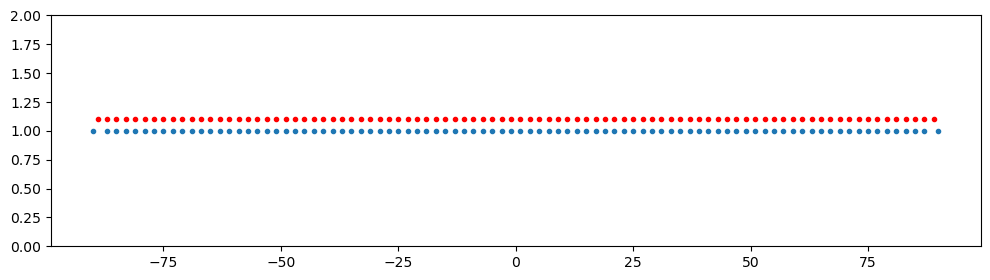

In [11]:
# grid for GISS has correct dimensions but different lat values at polar most gridcell
# the grid file came from PCMDI because GISS didn't supply a grid file
# not fixing this at the moment, but it could become a problem later

fig = plt.figure(figsize=(12,3))
ds= data_dict['GISS_E2.1_' +runlist[0]]
landfrac= data_dict['GISS_E2.1_' +'landfrac']

plt.plot(ds.lat,np.ones(len(ds.lat)),'.')
plt.plot(landfrac.lat,1.1*np.ones(len(landfrac.lat)),'.',color='red')
plt.ylim([0,2])


# Calculate Metrics

### zonal average land sink

Zonal average land sink is calculated from total carbon on land averaged into latitude bands

In [12]:
# example for one model and one experiment
# needs a loop to be broadcast to all runs
#m=0
#e=0
#var='cTot'

#- initialize
C_global_mat= np.empty([350,len(modellist),len(runlist),len(varlist)])
C_highlat_mat= np.empty([350,len(modellist),len(runlist),len(varlist)])
C_troplat_mat= np.empty([350,len(modellist),len(runlist),len(varlist)])
C_midlat_mat= np.empty([350,len(modellist),len(runlist),len(varlist)])

# create a time series of years for the first dimension
ts= np.arange(350)

for m in range(len(modellist)):
#for m in range(len(['GFDL-ESM4',  'GISS_E2.1',  'NorESM2-LM','MPI-ESM1-2-LR'])):
    model=modellist[m]
    print('loading model: ' +model)
    #----loop over experiments----# 
    for e in range(len(runlist)):
        run = runlist[e]
        print('loading run: ' +run)


        ds=data_dict[modellist[m] +'_' +runlist[e]]
        ds_area = data_dict[modellist[m] +'_' +'areacella']
        ds_landfrac = data_dict[modellist[m] +'_' +'landfrac']
        #area = ds_area['areacella'].expand_dims(dim={'time': ds.time.size}, axis=0)
        #landfrac=ds_landfrac['sftlf'].expand_dims(dim={'time': ds.time.size}, axis=0)
        
        
        if model=='CESM2':
            area = ds_area['areacella'].squeeze().reindex_like(ds, method='nearest',tolerance=0.05)
        elif model=='GISS_E2.1':
            area = ds_area['areacella'][:,-1]
        else:
            area = ds_area['areacella'].reindex_like(ds, method='nearest',tolerance=0.05)
        
        landfrac=ds_landfrac['sftlf'].reindex_like(ds, method='nearest',tolerance=0.05)
        
        if landfrac.max(dim=['lat','lon'])>1: #test if landfrac is on a 0-100 or 0-1 scale
            landfrac=landfrac/100
            
        landarea=area*landfrac
        
        troplat=30
        highlat=60
        


        #----loop over variables----#
        for v in range(len(varlist)):
            var=varlist[v]
            #print('loading variable: ' +var)

            data_var= weighted_temporal_mean(ds, var)

            # total carbon on land. Becuase it is in units of carbon/area (kgC/m2), multiply by area
            # our area variable is in m2
            C_global =(((data_var*landarea)).sum(dim=['lat','lon']))
            C_highlat=((data_var*landarea).where(ds.lat>=highlat)).sum(dim=['lat','lon'])
            C_troplat=((data_var*landarea).where((ds.lat>=-troplat) & (ds.lat<=troplat))).sum(dim=['lat','lon'])
            C_midlat=((data_var*landarea).where((ds.lat>=troplat) & (ds.lat<=highlat))).sum(dim=['lat','lon'])

            #put into matrix and convert to PgC (kgC => PgC, divide by 10^12)
            C_global_mat[0:len(C_global),m,e,v]= C_global*PgperKg
            C_highlat_mat[0:len(C_global),m,e,v]= C_highlat*PgperKg
            C_troplat_mat[0:len(C_global),m,e,v]= C_troplat*PgperKg
            C_midlat_mat[0:len(C_global),m,e,v]= C_midlat*PgperKg




## for per area variables need area weighting
#cTot_global = (((ds[var]*landarea)).sum(dim=['lat','lon']))/(landarea.sum(dim=['lat','lon']))
#cTot_highlat=((ds[var]*landarea).where(ds.lat>=highlat)).sum(dim=['lat','lon'])/(landarea.where(ds.lat>=highlat).sum(dim=['lat','lon']))
#cTot_troplat=((ds[var]*landarea).where((ds.lat>=-troplat) & (ds.lat<=troplat))).sum(dim=['lat','lon'])/(landarea.where((ds.lat>=-troplat) & (ds.lat<=troplat)).sum(dim=['lat','lon']))
#cTot_midlat=((ds[var]*landarea).where((ds.lat>=troplat) & (ds.lat<=highlat))).sum(dim=['lat','lon'])/(landarea.where((ds.lat>=troplat) & (ds.lat<=highlat)).sum(dim=['lat','lon']))


 #----merge all variables into one dataset----#
# if it's the first variable, then start a new datset, otherwise merge with existing
#if v ==0:
#    ds_cTot_global = cTot_global.copy()
#else:
#    #dsmerge_v=xr.merge([dsmerge_v, dsmerge_f])
#    ds_cTot_global = xr.merge([ds_cTot_global, cTot_global])

#dsmerge_v=xr.merge([dsmerge_v, dsmerge_f])

loading model: ACCESS-ESM1-5
loading run: flat10
loading run: flat10_zec
loading run: flat10_cdr
loading model: CESM2
loading run: flat10
loading run: flat10_zec
loading run: flat10_cdr
loading model: GFDL-ESM4
loading run: flat10
loading run: flat10_zec
loading run: flat10_cdr
loading model: GISS_E2.1
loading run: flat10
loading run: flat10_zec
loading run: flat10_cdr
loading model: NorESM2-LM
loading run: flat10
loading run: flat10_zec
loading run: flat10_cdr
loading model: MPI-ESM1-2-LR
loading run: flat10
loading run: flat10_zec
loading run: flat10_cdr
loading model: CNRM-ESM2-1
loading run: flat10
loading run: flat10_zec
loading run: flat10_cdr
loading model: HadCM3LC-Bris
loading run: flat10
loading run: flat10_zec
loading run: flat10_cdr


In [13]:
ds_area

<xarray.Dataset>
Dimensions:         (lat: 73, lon: 96, bnds: 2)
Coordinates:
  * lat             (lat) float32 90.0 87.5 85.0 82.5 ... -85.0 -87.5 -90.0
  * lon             (lon) float32 0.0 3.75 7.5 11.25 ... 345.0 348.8 352.5 356.2
    surface         float32 ...
    time            object ...
Dimensions without coordinates: bnds
Data variables:
    areacella       (lat, lon) float32 ...
    latitude_bnds   (lat, bnds) float32 ...
    longitude_bnds  (lon, bnds) float64 ...
Attributes:
    date:         00/12/50
    history:      Tue Mar 25 03:22:23 GMT 2025 - XCONV V1.91 Development
    name:         cell_area
    source:       Unified Model Output (Vn 4.6):
    time:         00:00
    Conventions:  CF-1.7

In [23]:
# put the matrix into an xarray dataset

data_array_combined = np.full((len(ts), len(modellist), len(runlist), len(varlist), len(latlist)),np.nan)

data_array_combined[:,:,:,:,0]=C_global_mat
data_array_combined[:,:,:,:,1]=C_highlat_mat
data_array_combined[:,:,:,:,2]=C_troplat_mat
data_array_combined[:,:,:,:,3]=C_midlat_mat

In [24]:
np.shape(data_array_combined)

(350, 8, 3, 7, 4)

In [25]:
latlist=['global','highlat','troplat','midlat']

ds_C_global= xr.Dataset(
    {
        "data": (["time", "model", "run", "var","latrange"], data_array_combined)
    },
    coords={
        "time": ts,
        "model": modellist,
        "run": runlist,
        "var": varlist,
        "latrange": latlist
    }
)

In [26]:
ds_C_global

<xarray.Dataset>
Dimensions:   (time: 350, model: 8, run: 3, var: 7, latrange: 4)
Coordinates:
  * time      (time) int64 0 1 2 3 4 5 6 7 8 ... 342 343 344 345 346 347 348 349
  * model     (model) <U13 'ACCESS-ESM1-5' 'CESM2' ... 'HadCM3LC-Bris'
  * run       (run) <U10 'flat10' 'flat10_zec' 'flat10_cdr'
  * var       (var) <U7 'cVeg' 'cSoil' 'cTot' 'cLitter' 'nbp' 'gpp' 'rh'
  * latrange  (latrange) <U7 'global' 'highlat' 'troplat' 'midlat'
Data variables:
    data      (time, model, run, var, latrange) float64 645.3 38.02 ... nan nan

In [27]:
ds_C_global.to_netcdf("C_metrics_matrix.nc")

# Plots

In [58]:
# switch to the list of variables to analyze

varlist=varlist_analyze

print(varlist)

['cVeg', 'cSoil', 'cTot', 'cLitter', 'nbp', 'gpp', 'rh']


<xarray.Dataset>
Dimensions:   (time: 350)
Coordinates:
  * time      (time) int64 0 1 2 3 4 5 6 7 8 ... 342 343 344 345 346 347 348 349
    model     <U13 'ACCESS-ESM1-5'
    run       <U10 'flat10'
    var       <U7 'cTot'
    latrange  <U7 'global'
Data variables:
    data      (time) float64 1.47e+03 1.47e+03 ... 2.247e+307 2.247e+307


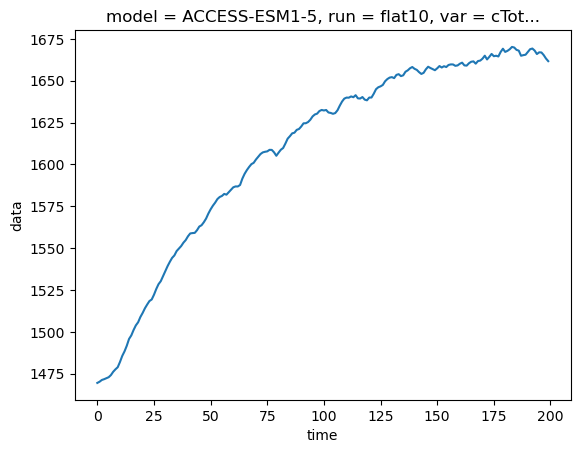

In [33]:
# to load data from this ds

# Access data for one model, run, var
#subset = ds.sel(time=0.1, model='model1', run='run1', var='var1')

subset = ds_C_global.sel(model=modellist[0], run=runlist[0], var='cTot', latrange='global')

print(subset)

subset.data[0:200].plot()

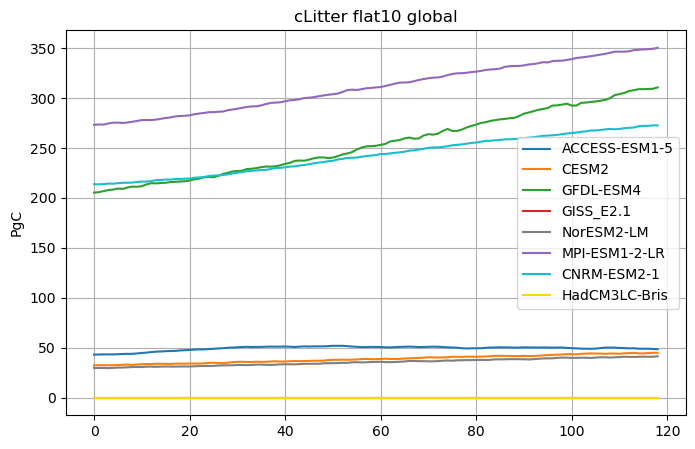

In [55]:
fig = plt.figure(figsize=(8,5))

e=0
v=2
l=0
for m in range(len(modellist)):
    mcolor=modelcolors[m]
    timeseries=ds_C_global.sel(model=modellist[m], run=runlist[e], var=varlist[v], latrange=latlist[l])
    
    plt.plot(timeseries.data[1:120].values,label=modellist[m],color=mcolor)

plt.title(varlist[v] +' ' +runlist[e] +' ' +latlist[l])# +modellist[0] 
plt.ylabel('PgC')
plt.legend()
plt.grid()

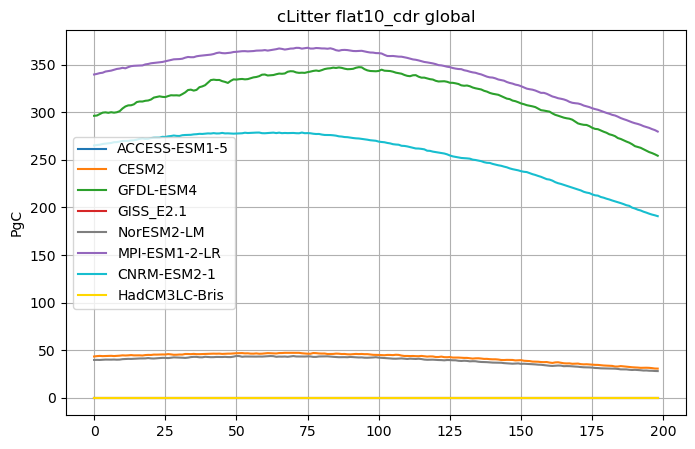

In [56]:
fig = plt.figure(figsize=(8,5))

e=2
v=2
l=0
for m in range(len(modellist)):
    mcolor=modelcolors[m]
    timeseries=ds_C_global.sel(model=modellist[m], run=runlist[e], var=varlist[v], latrange=latlist[l])
    
    plt.plot(timeseries.data[1:200].values,label=modellist[m],color=mcolor)

plt.title(varlist[v] +' ' +runlist[e] +' ' +latlist[l])# +modellist[0] 
plt.ylabel('PgC')
plt.legend()
plt.grid()

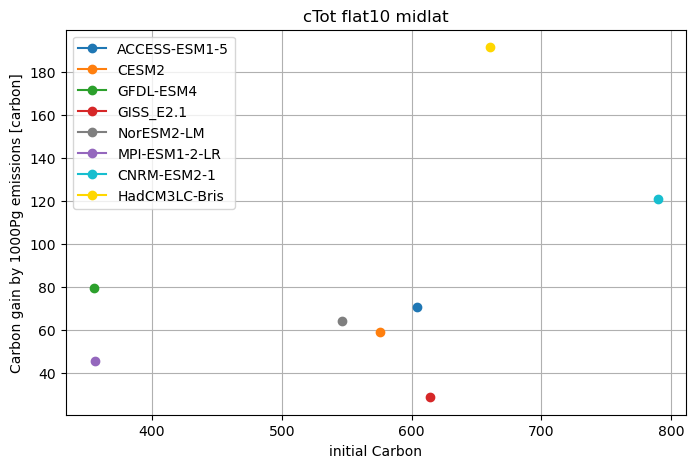

In [62]:
fig = plt.figure(figsize=(8,5))


e=0
v=2
l=3
for m in range(len(modellist)):
    model=modellist[m]
    mcolor=modelcolors[m]
    timeseries=ds_C_global.sel(model=modellist[m], run=runlist[e], var=varlist[v], latrange=latlist[l])
    initC=np.mean(timeseries.data[0:9])
    nzC=np.mean(timeseries.data[90:109])
    plt.plot(initC,nzC-initC,marker='o',label=model,color=mcolor)


plt.title(varlist[v] +' ' +runlist[e] +' ' +latlist[l])
plt.ylabel('Carbon gain by 1000Pg emissions [carbon]')
plt.xlabel('initial Carbon')
plt.legend()
plt.grid()

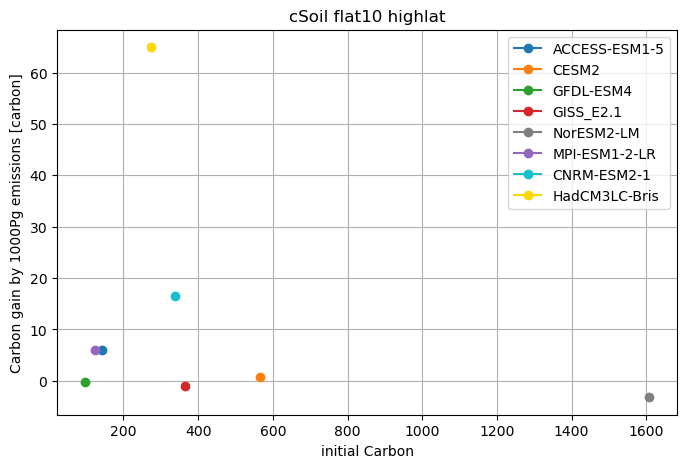

In [64]:
fig = plt.figure(figsize=(8,5))


e=0
v=1
l=1
for m in range(len(modellist)):
    model=modellist[m]
    mcolor=modelcolors[m]
    timeseries=ds_C_global.sel(model=modellist[m], run=runlist[e], var=varlist[v], latrange=latlist[l])
    initC=np.mean(timeseries.data[0:9])
    nzC=np.mean(timeseries.data[90:109])
    plt.plot(initC,nzC-initC,marker='o',label=model,color=mcolor)


plt.title(varlist[v] +' ' +runlist[e] +' ' +latlist[l])
plt.ylabel('Carbon gain by 1000Pg emissions [carbon]')
plt.xlabel('initial Carbon')
plt.legend()
plt.grid()

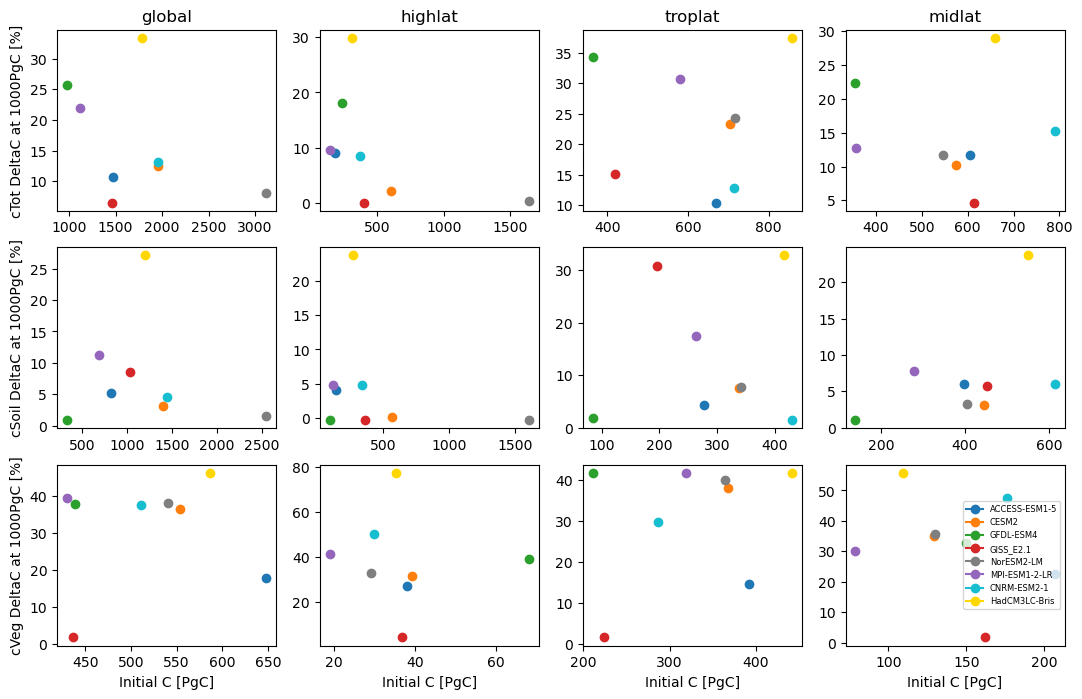

In [67]:
fig, axes = plt.subplots(3,4,figsize=(13, 8))
#axes=axes.flatten()

# rows are carbon variables, cTot, cVeg, cSoil
# columns are % change
vlist = [2,1,0]
e=0

for m in range(len(modellist)):
    model=modellist[m]
    mcolor=modelcolors[m]

    for vi in range(len(vlist)):
        v=vlist[vi]
        for l in range(len(latlist)):
            timeseries=ds_C_global.sel(model=modellist[m], run=runlist[e], 
                                       var=varlist[v], latrange=latlist[l])
            initC=np.mean(timeseries.data[0:9])
            nzC=np.mean(timeseries.data[90:109])
            axes[vi,l].plot(initC,100*(nzC-initC)/initC,marker='o',label=model,color=mcolor)
            axes[vi,l].grid()
    

axes[0,0].set_title(latlist[0])
axes[0,1].set_title(latlist[1])
axes[0,2].set_title(latlist[2])
axes[0,3].set_title(latlist[3])


axes[2,0].set_xlabel('Initial C [PgC]')
axes[2,1].set_xlabel('Initial C [PgC]')
axes[2,2].set_xlabel('Initial C [PgC]')
axes[2,3].set_xlabel('Initial C [PgC]')

axes[0,0].set_ylabel(varlist[vlist[0]] +' DeltaC at 1000PgC [%]')
axes[1,0].set_ylabel(varlist[vlist[1]] +' DeltaC at 1000PgC [%]')
axes[2,0].set_ylabel(varlist[vlist[2]] +' DeltaC at 1000PgC [%]')
#axes[3,0].set_ylabel(var +'DeltaC at 1000PgC [%]')

axes[2,3].legend(fontsize=6)

plt.savefig("figures/deltaCscatter_pct.pdf", bbox_inches='tight')
plt.savefig("figures/deltaCscatter_pct.jpg", bbox_inches='tight')


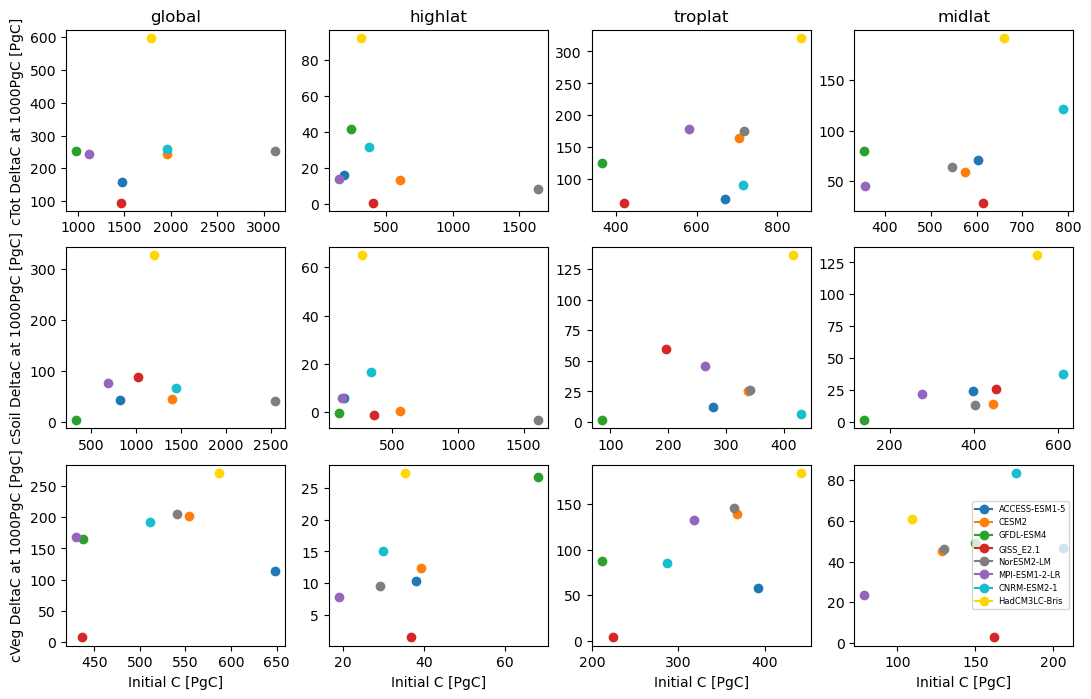

In [68]:
fig, axes = plt.subplots(3,4,figsize=(13, 8))
#axes=axes.flatten()

# rows are carbon variables, cTot, cVeg, cSoil
# columns are total change
vlist = [2,1,0]
e=0

for m in range(len(modellist)):
    model=modellist[m]
    mcolor=modelcolors[m]

    for vi in range(len(vlist)):
        v=vlist[vi]
        for l in range(len(latlist)):
            timeseries=ds_C_global.sel(model=modellist[m], run=runlist[e], 
                                       var=varlist[v], latrange=latlist[l])
            initC=np.mean(timeseries.data[0:9])
            nzC=np.mean(timeseries.data[90:109])
            axes[vi,l].plot(initC,(nzC-initC),marker='o',label=model,color=mcolor)
            axes[vi,l].grid()
    

axes[0,0].set_title(latlist[0])
axes[0,1].set_title(latlist[1])
axes[0,2].set_title(latlist[2])
axes[0,3].set_title(latlist[3])


axes[2,0].set_xlabel('Initial C [PgC]')
axes[2,1].set_xlabel('Initial C [PgC]')
axes[2,2].set_xlabel('Initial C [PgC]')
axes[2,3].set_xlabel('Initial C [PgC]')

axes[0,0].set_ylabel(varlist[vlist[0]] +' DeltaC at 1000PgC [PgC]')
axes[1,0].set_ylabel(varlist[vlist[1]] +' DeltaC at 1000PgC [PgC]')
axes[2,0].set_ylabel(varlist[vlist[2]] +' DeltaC at 1000PgC [PgC]')
#axes[3,0].set_ylabel(var +'DeltaC at 1000PgC [%]')

axes[2,3].legend(fontsize=6)

plt.savefig("figures/deltaCscatter_PgC.pdf", bbox_inches='tight')
plt.savefig("figures/deltaCscatter_PgC.jpg", bbox_inches='tight')


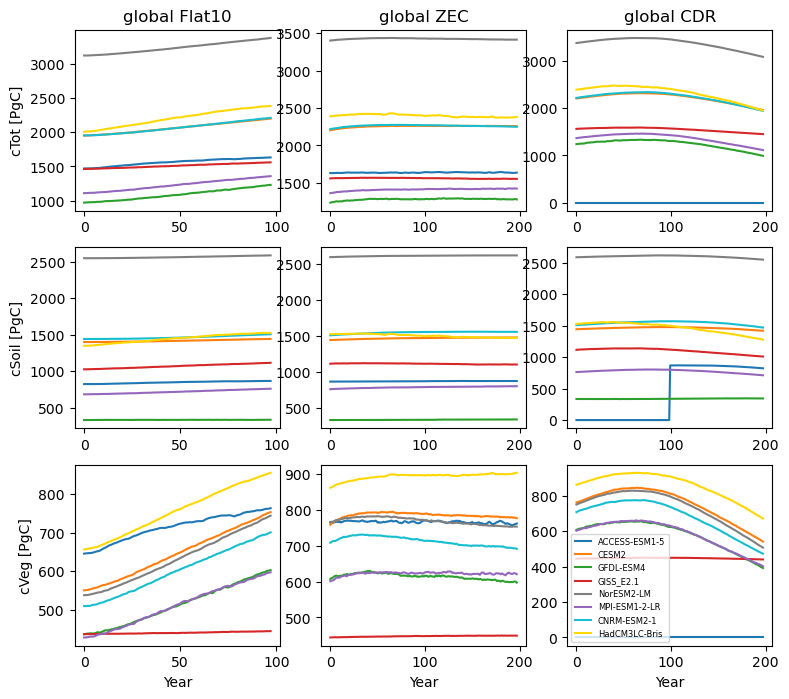

In [72]:
fig, axes = plt.subplots(3,3,figsize=(9, 8))
#axes=axes.flatten()

# rows are carbon variables, cTot, cVeg, cSoil
# columns are total change, % change
vlist = [2,1,0]
l=0

for m in range(len(modellist)):
    model=modellist[m]
    mcolor=modelcolors[m]

    for vi in range(len(vlist)):
        v=vlist[vi]
        e=0
        timeseries=ds_C_global.sel(model=modellist[m], run=runlist[e], 
                                       var=varlist[v], latrange=latlist[l])
        Cts=timeseries.data[1:99]
        axes[vi,0].plot(Cts,label=model,color=mcolor)

        e=1
        timeseries=ds_C_global.sel(model=modellist[m], run=runlist[e], 
                                       var=varlist[v], latrange=latlist[l])
        Cts=timeseries.data[1:199]
        axes[vi,1].plot(Cts,label=model,color=mcolor)

        e=2
        timeseries=ds_C_global.sel(model=modellist[m], run=runlist[e], 
                                       var=varlist[v], latrange=latlist[l])
        Cts=timeseries.data[1:199]
        axes[vi,2].plot(Cts,label=model,color=mcolor)



axes[0,0].set_title(latlist[l] +' Flat10')
axes[0,1].set_title(latlist[l] +' ZEC')
axes[0,2].set_title(latlist[l] +' CDR')


axes[2,0].set_xlabel('Year')
axes[2,1].set_xlabel('Year')
axes[2,2].set_xlabel('Year')

axes[0,0].set_ylabel(varlist[vlist[0]] +' [PgC]')
axes[1,0].set_ylabel(varlist[vlist[1]] +' [PgC]')
axes[2,0].set_ylabel(varlist[vlist[2]] +' [PgC]')
#axes[3,0].set_ylabel(var +'DeltaC at 1000PgC [%]')

axes[2,2].legend(fontsize=6)

plt.savefig("figures/Ctimeseries_" +latlist[l] +"_PgC.pdf", bbox_inches='tight')
plt.savefig("figures/Ctimeseries_" +latlist[l] +"_PgC.png", bbox_inches='tight')


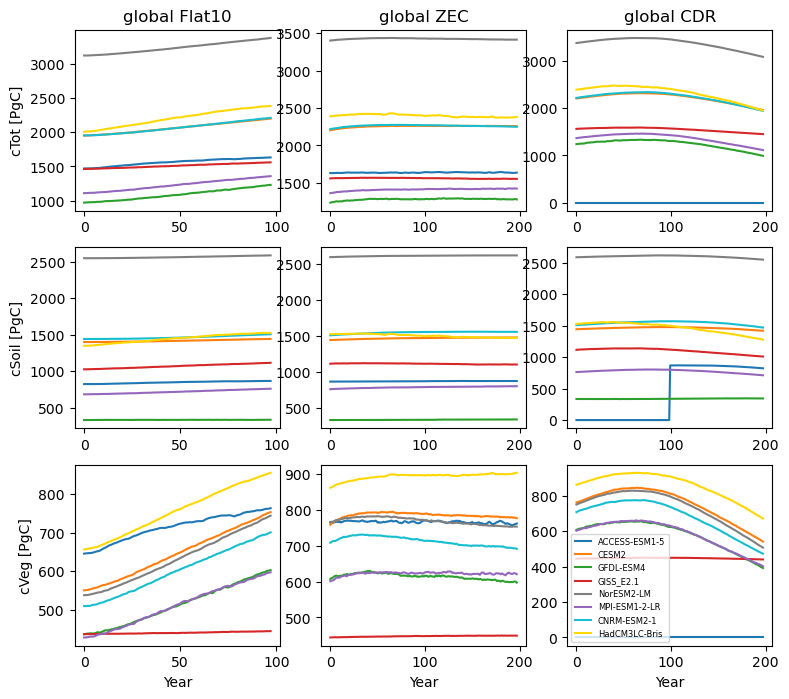

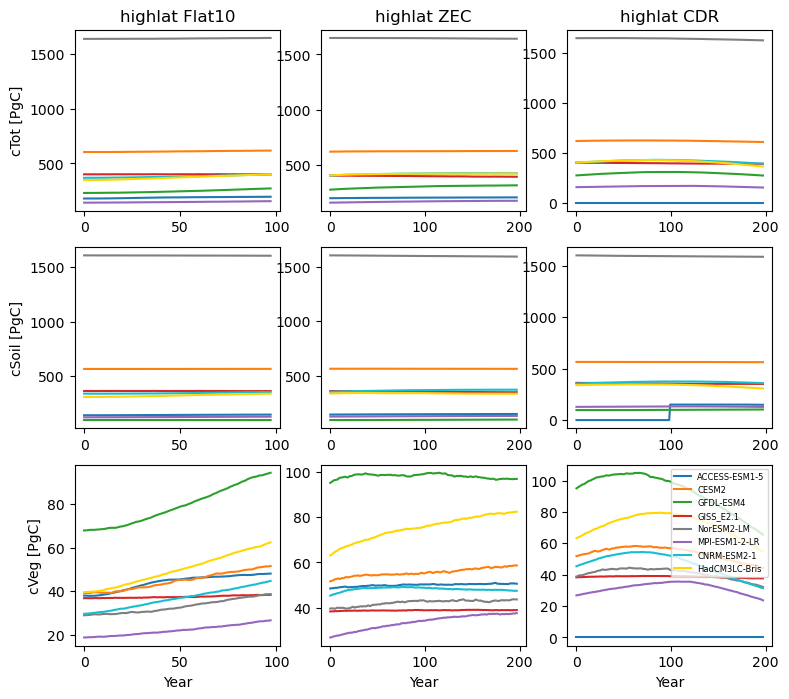

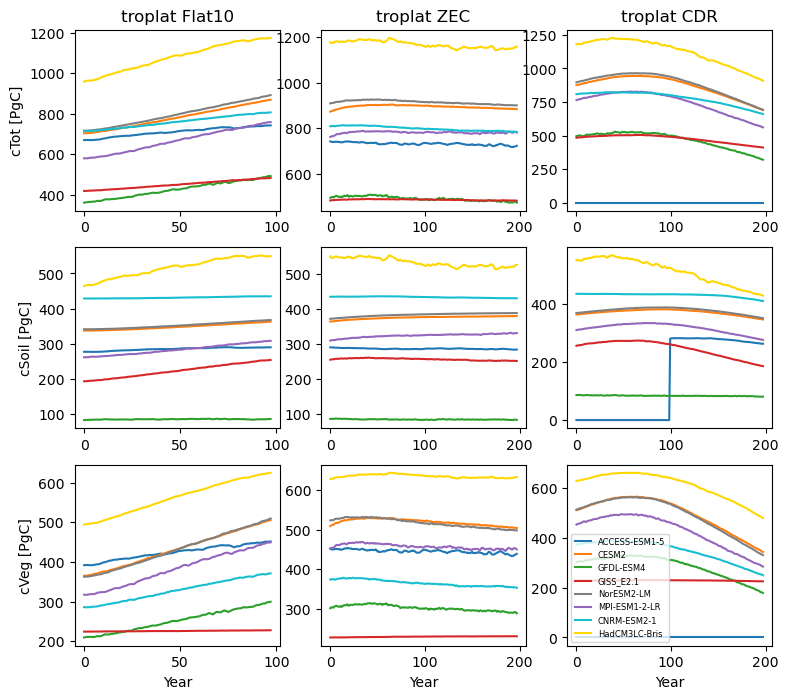

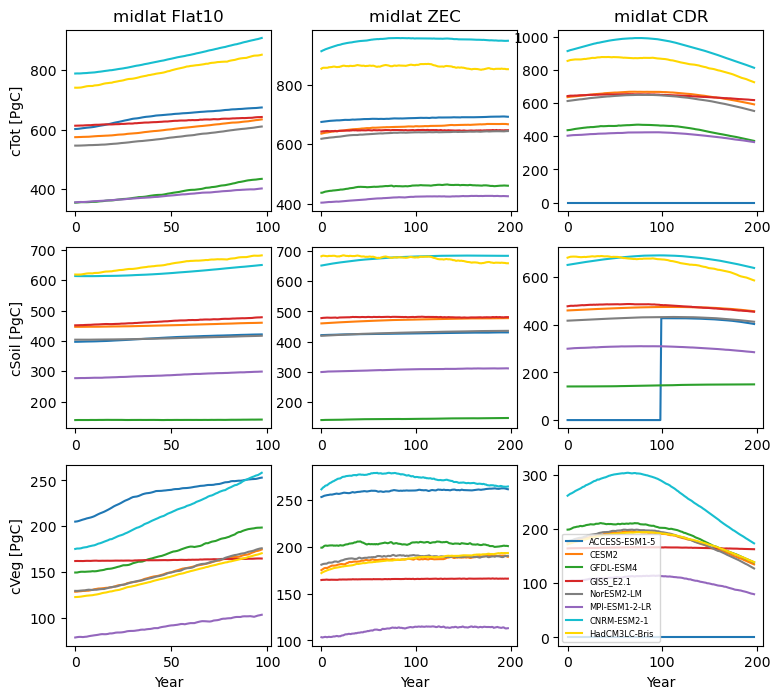

In [73]:
# loop over all latitude bands
for l in range(len(latlist)):

    fig, axes = plt.subplots(3,3,figsize=(9, 8))
    #axes=axes.flatten()
    
    # rows are carbon variables, cTot, cVeg, cSoil
    # columns are total change, % change
    vlist = [2,1,0]
    
    for m in range(len(modellist)):
        model=modellist[m]
        mcolor=modelcolors[m]
    
        for vi in range(len(vlist)):
            v=vlist[vi]
            e=0
            timeseries=ds_C_global.sel(model=modellist[m], run=runlist[e], 
                                           var=varlist[v], latrange=latlist[l])
            Cts=timeseries.data[1:99]
            axes[vi,0].plot(Cts,label=model,color=mcolor)
    
            e=1
            timeseries=ds_C_global.sel(model=modellist[m], run=runlist[e], 
                                           var=varlist[v], latrange=latlist[l])
            Cts=timeseries.data[1:199]
            axes[vi,1].plot(Cts,label=model,color=mcolor)
    
            e=2
            timeseries=ds_C_global.sel(model=modellist[m], run=runlist[e], 
                                           var=varlist[v], latrange=latlist[l])
            Cts=timeseries.data[1:199]
            axes[vi,2].plot(Cts,label=model,color=mcolor)
    
    
    
    axes[0,0].set_title(latlist[l] +' Flat10')
    axes[0,1].set_title(latlist[l] +' ZEC')
    axes[0,2].set_title(latlist[l] +' CDR')
    
    
    axes[2,0].set_xlabel('Year')
    axes[2,1].set_xlabel('Year')
    axes[2,2].set_xlabel('Year')
    
    axes[0,0].set_ylabel(varlist[vlist[0]] +' [PgC]')
    axes[1,0].set_ylabel(varlist[vlist[1]] +' [PgC]')
    axes[2,0].set_ylabel(varlist[vlist[2]] +' [PgC]')
    #axes[3,0].set_ylabel(var +'DeltaC at 1000PgC [%]')
    
    axes[2,2].legend(fontsize=6)
    
    plt.savefig("figures/Ctimeseries_" +latlist[l] +"_PgC.pdf", bbox_inches='tight')
    plt.savefig("figures/Ctimeseries_" +latlist[l] +"_PgC.png", bbox_inches='tight')


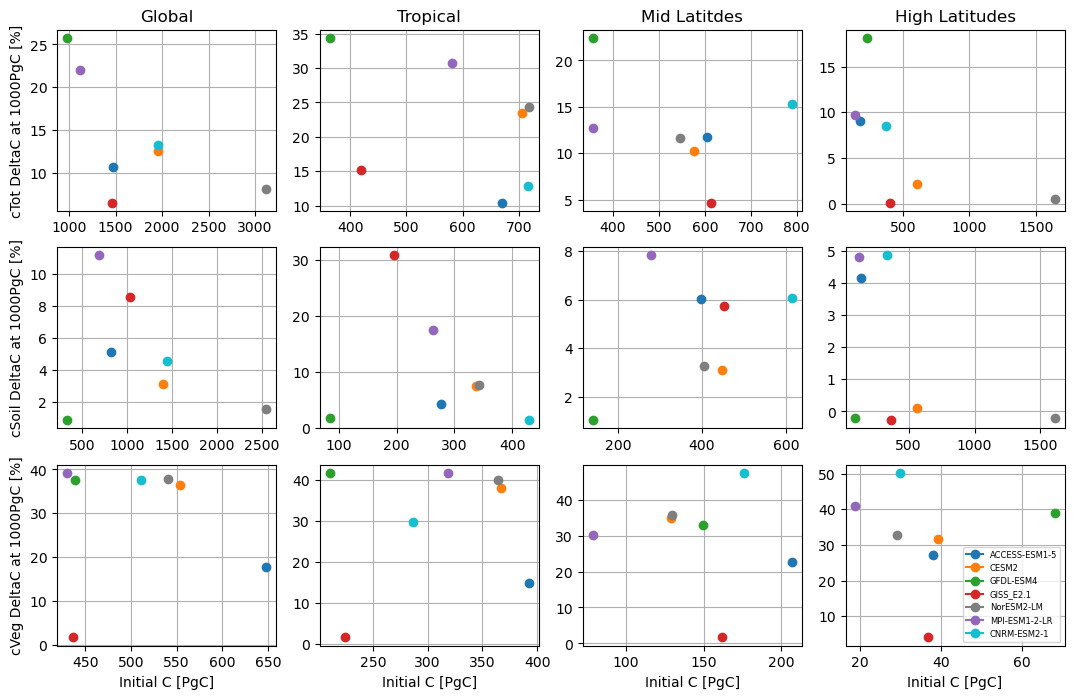

In [381]:
'''fig, axes = plt.subplots(3,4,figsize=(13, 8))
#axes=axes.flatten()

# rows are carbon variables, cTot, cVeg, cSoil
# columns are total change, % change
vlist = [2,1,0]
e=0

for m in range(len(modellist)):
    model=modellist[m]
    mcolor=modelcolors[m]

    for vi in range(len(vlist)):
        v=vlist[vi]
        for l in range(len(latlist)):
            timeseries=ds_C_global.sel(model=modellist[m], run=runlist[e], var=varlist[v], latrange=latlist[l])
            initC=np.mean(timeseries.data[0:9])
            nzC=np.mean(timeseries.data[90:109])
            axes[vi,0].plot(initC,100*(nzC-initC)/initC,marker='o',label=model,color=mcolor)
            axes[v,0].grid()
    
        initC=np.mean(C_troplat_mat[0:9,m,e,v])
        nzC=np.mean(C_troplat_mat[90:109,m,e,v])
        axes[vi,1].plot(initC,100*(nzC-initC)/initC,marker='o',label=model,color=mcolor)
        axes[v,1].grid()
    
        initC=np.mean(C_midlat_mat[0:9,m,e,v])
        nzC=np.mean(C_midlat_mat[90:109,m,e,v])
        axes[vi,2].plot(initC,100*(nzC-initC)/initC,marker='o',label=model,color=mcolor)
        axes[v,2].grid() 
    
        initC=np.mean(C_highlat_mat[0:9,m,e,v])
        nzC=np.mean(C_highlat_mat[90:109,m,e,v])
        axes[vi,3].plot(initC,100*(nzC-initC)/initC,marker='o',label=model,color=mcolor)
        axes[v,3].grid() 


axes[0,0].set_title('Global')
axes[0,1].set_title('Tropical')
axes[0,2].set_title('Mid Latitdes')
axes[0,3].set_title('High Latitudes')


axes[2,0].set_xlabel('Initial C [PgC]')
axes[2,1].set_xlabel('Initial C [PgC]')
axes[2,2].set_xlabel('Initial C [PgC]')
axes[2,3].set_xlabel('Initial C [PgC]')

axes[0,0].set_ylabel(varlist[vlist[0]] +' DeltaC at 1000PgC [%]')
axes[1,0].set_ylabel(varlist[vlist[1]] +' DeltaC at 1000PgC [%]')
axes[2,0].set_ylabel(varlist[vlist[2]] +' DeltaC at 1000PgC [%]')
#axes[3,0].set_ylabel(var +'DeltaC at 1000PgC [%]')

axes[2,3].legend(fontsize=6)

plt.savefig("figures/deltaCscatter_pct.pdf", bbox_inches='tight')
plt.savefig("figures/deltaCscatter_pct.jpg", bbox_inches='tight')


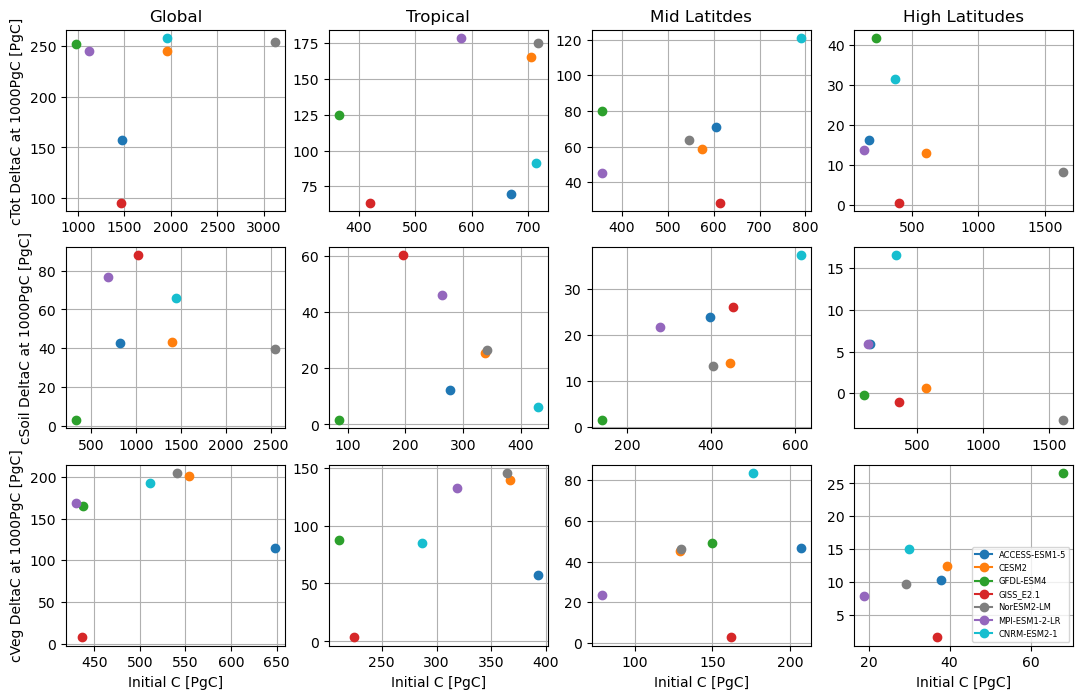

In [382]:
'''fig, axes = plt.subplots(3,4,figsize=(13, 8))
#axes=axes.flatten()

# rows are carbon variables, cTot, cVeg, cSoil
# columns are total change, % change
vlist = [2,1,0]
e=0

for m in range(len(modellist)):
    model=modellist[m]
    mcolor=modelcolors[m]

    for vi in range(len(vlist)):
        v=vlist[vi]
        initC=np.mean(C_global_mat[0:9,m,e,v])
        nzC=np.mean(C_global_mat[90:109,m,e,v])
        axes[vi,0].plot(initC,(nzC-initC),marker='o',label=model,color=mcolor)
        axes[vi,0].grid()
    
        initC=np.mean(C_troplat_mat[0:9,m,e,v])
        nzC=np.mean(C_troplat_mat[90:109,m,e,v])
        axes[vi,1].plot(initC,(nzC-initC),marker='o',label=model,color=mcolor)
        axes[vi,1].grid()
    
        initC=np.mean(C_midlat_mat[0:9,m,e,v])
        nzC=np.mean(C_midlat_mat[90:109,m,e,v])
        axes[vi,2].plot(initC,(nzC-initC),marker='o',label=model,color=mcolor)
        axes[vi,2].grid() 
    
        initC=np.mean(C_highlat_mat[0:9,m,e,v])
        nzC=np.mean(C_highlat_mat[90:109,m,e,v])
        axes[vi,3].plot(initC,(nzC-initC),marker='o',label=model,color=mcolor)
        axes[vi,3].grid()


axes[0,0].set_title('Global')
axes[0,1].set_title('Tropical')
axes[0,2].set_title('Mid Latitdes')
axes[0,3].set_title('High Latitudes')


axes[2,0].set_xlabel('Initial C [PgC]')
axes[2,1].set_xlabel('Initial C [PgC]')
axes[2,2].set_xlabel('Initial C [PgC]')
axes[2,3].set_xlabel('Initial C [PgC]')

axes[0,0].set_ylabel(varlist[vlist[0]] +' DeltaC at 1000PgC [PgC]')
axes[1,0].set_ylabel(varlist[vlist[1]] +' DeltaC at 1000PgC [PgC]')
axes[2,0].set_ylabel(varlist[vlist[2]] +' DeltaC at 1000PgC [PgC]')
#axes[3,0].set_ylabel(var +'DeltaC at 1000PgC [%]')

axes[2,3].legend(fontsize=6)

plt.savefig("figures/deltaCscatter_PgC.pdf", bbox_inches='tight')
plt.savefig("figures/deltaCscatter_PgC.jpg", bbox_inches='tight')


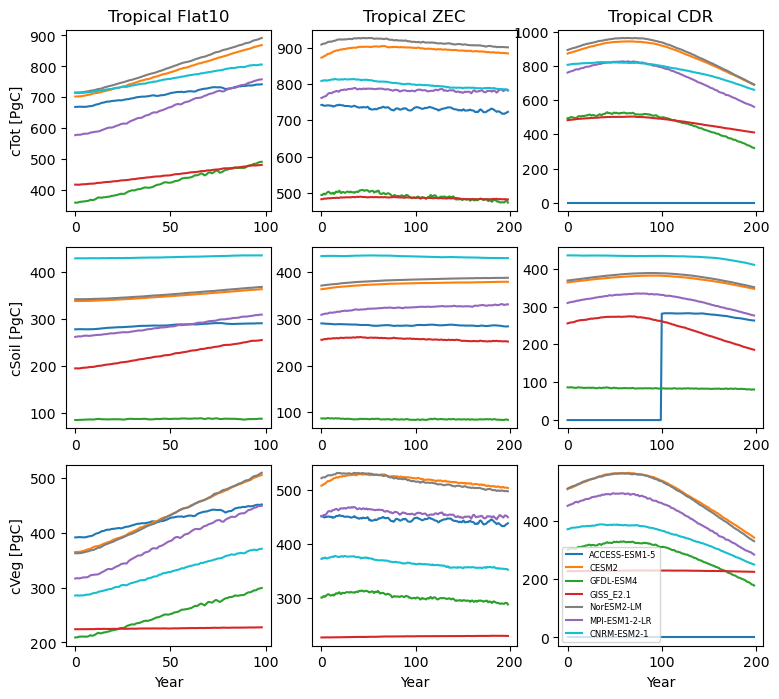

In [384]:
fig, axes = plt.subplots(3,3,figsize=(9, 8))
#axes=axes.flatten()

# rows are carbon variables, cTot, cVeg, cSoil
# columns are total change, % change
vlist = [2,1,0]

for m in range(len(modellist)):
    model=modellist[m]
    mcolor=modelcolors[m]

    for vi in range(len(vlist)):
        v=vlist[vi]
        e=0
        Cts=C_troplat_mat[0:99,m,e,v]
        axes[vi,0].plot(Cts,label=model,color=mcolor)

        e=1
        Cts=C_troplat_mat[0:199,m,e,v]
        axes[vi,1].plot(Cts,label=model,color=mcolor)

        e=2
        Cts=C_troplat_mat[0:199,m,e,v]
        axes[vi,2].plot(Cts,label=model,color=mcolor)



axes[0,0].set_title('Tropical ' +'Flat10')
axes[0,1].set_title('Tropical ' +'ZEC')
axes[0,2].set_title('Tropical ' +'CDR')


axes[2,0].set_xlabel('Year')
axes[2,1].set_xlabel('Year')
axes[2,2].set_xlabel('Year')

axes[0,0].set_ylabel(varlist[vlist[0]] +' [PgC]')
axes[1,0].set_ylabel(varlist[vlist[1]] +' [PgC]')
axes[2,0].set_ylabel(varlist[vlist[2]] +' [PgC]')
#axes[3,0].set_ylabel(var +'DeltaC at 1000PgC [%]')

axes[2,2].legend(fontsize=6)

plt.savefig("figures/Ctimeseries_troplat_PgC.pdf", bbox_inches='tight')
plt.savefig("figures/Ctimeseries_troplat_PgC.jpg", bbox_inches='tight')


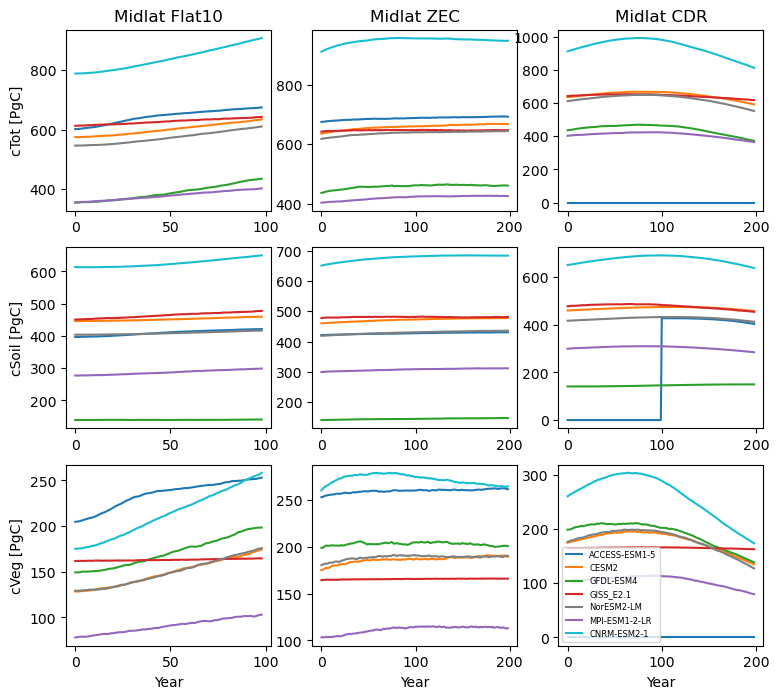

In [385]:
fig, axes = plt.subplots(3,3,figsize=(9, 8))
#axes=axes.flatten()

# rows are carbon variables, cTot, cVeg, cSoil
# columns are total change, % change
vlist = [2,1,0]

for m in range(len(modellist)):
    model=modellist[m]
    mcolor=modelcolors[m]

    for vi in range(len(vlist)):
        v=vlist[vi]
        e=0
        Cts=C_midlat_mat[0:99,m,e,v]
        axes[vi,0].plot(Cts,label=model,color=mcolor)

        e=1
        Cts=C_midlat_mat[0:199,m,e,v]
        axes[vi,1].plot(Cts,label=model,color=mcolor)

        e=2
        Cts=C_midlat_mat[0:199,m,e,v]
        axes[vi,2].plot(Cts,label=model,color=mcolor)



axes[0,0].set_title('Midlat ' +'Flat10')
axes[0,1].set_title('Midlat ' +'ZEC')
axes[0,2].set_title('Midlat ' +'CDR')


axes[2,0].set_xlabel('Year')
axes[2,1].set_xlabel('Year')
axes[2,2].set_xlabel('Year')

axes[0,0].set_ylabel(varlist[vlist[0]] +' [PgC]')
axes[1,0].set_ylabel(varlist[vlist[1]] +' [PgC]')
axes[2,0].set_ylabel(varlist[vlist[2]] +' [PgC]')
#axes[3,0].set_ylabel(var +'DeltaC at 1000PgC [%]')

axes[2,2].legend(fontsize=6)

plt.savefig("figures/Ctimeseries_midlat_PgC.pdf", bbox_inches='tight')
plt.savefig("figures/Ctimeseries_midlat_PgC.jpg", bbox_inches='tight')


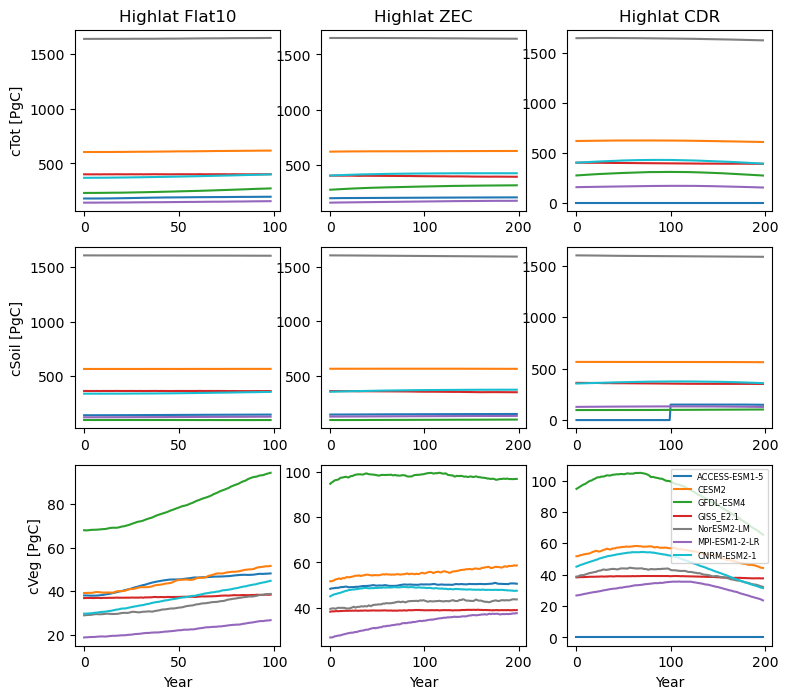

In [387]:
fig, axes = plt.subplots(3,3,figsize=(9, 8))
#axes=axes.flatten()

# rows are carbon variables, cTot, cVeg, cSoil
# columns are total change, % change
vlist = [2,1,0]

for m in range(len(modellist)):
    model=modellist[m]
    mcolor=modelcolors[m]

    for vi in range(len(vlist)):
        v=vlist[vi]
        e=0
        Cts=C_highlat_mat[0:99,m,e,v]
        axes[vi,0].plot(Cts,label=model,color=mcolor)

        e=1
        Cts=C_highlat_mat[0:199,m,e,v]
        axes[vi,1].plot(Cts,label=model,color=mcolor)

        e=2
        Cts=C_highlat_mat[0:199,m,e,v]
        axes[vi,2].plot(Cts,label=model,color=mcolor)



axes[0,0].set_title('Highlat ' +'Flat10')
axes[0,1].set_title('Highlat ' +'ZEC')
axes[0,2].set_title('Highlat ' +'CDR')


axes[2,0].set_xlabel('Year')
axes[2,1].set_xlabel('Year')
axes[2,2].set_xlabel('Year')

axes[0,0].set_ylabel(varlist[vlist[0]] +' [PgC]')
axes[1,0].set_ylabel(varlist[vlist[1]] +' [PgC]')
axes[2,0].set_ylabel(varlist[vlist[2]] +' [PgC]')
#axes[3,0].set_ylabel(var +'DeltaC at 1000PgC [%]')

axes[2,2].legend(fontsize=6)

plt.savefig("figures/Ctimeseries_highlat_PgC.pdf", bbox_inches='tight')
plt.savefig("figures/Ctimeseries_highlat_PgC.jpg", bbox_inches='tight')


### vegetation vs. soil sinks

vegetation and soil sinks are calculated from vegetation carbon and soil carbon

we want to know the initital stocks as well as the change over time under different experiemnts



### reversibility

reversibility is the state of the system after cumulative emissions reach zero in the flat10-cdr experiment

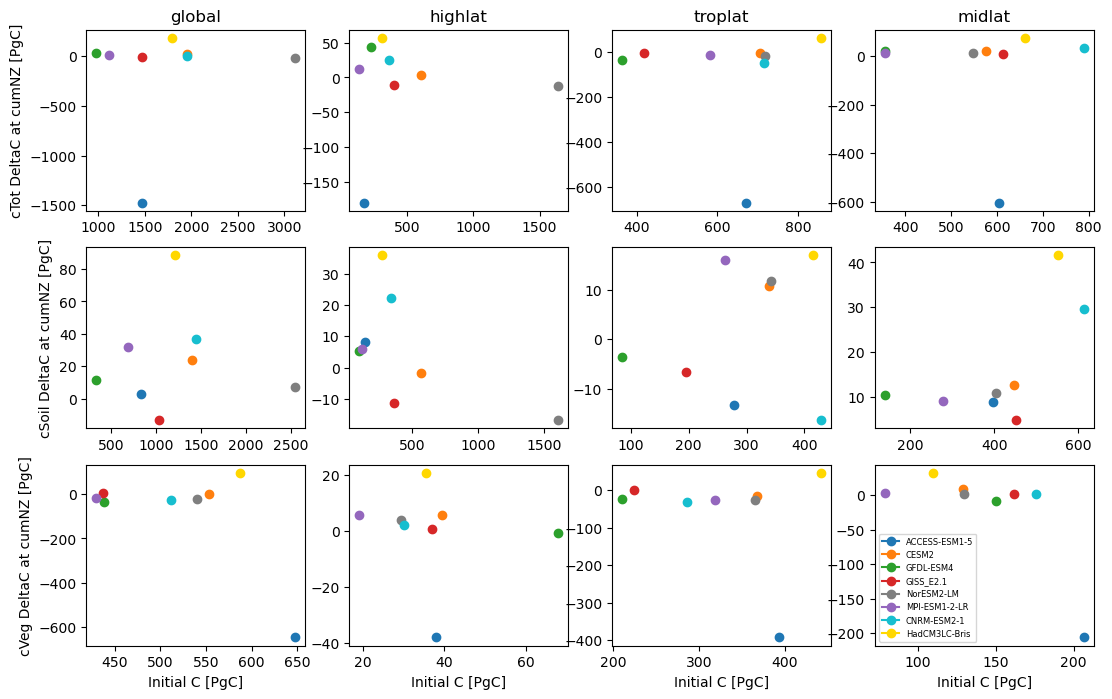

In [76]:
### This is not working right becuase the cdr experiment for access has data problems

fig, axes = plt.subplots(3,4,figsize=(13, 8))
#axes=axes.flatten()

# rows are carbon variables, cTot, cVeg, cSoil
# columns are total change, % change
vlist = [2,1,0]

for m in range(len(modellist)):
    model=modellist[m]
    mcolor=modelcolors[m]

    for vi in range(len(vlist)):
        v=vlist[vi]
        for l in range(len(latlist)):
            e=0
            timeseries=ds_C_global.sel(model=modellist[m], run=runlist[e], 
                                           var=varlist[v], latrange=latlist[l])
            initC=np.mean(timeseries.data[0:9])
            
            e=2
            timeseries=ds_C_global.sel(model=modellist[m], run=runlist[e], 
                                           var=varlist[v], latrange=latlist[l])
            
            nzC=np.mean(timeseries.data[190:199])
            axes[vi,l].plot(initC,(nzC-initC),marker='o',label=model,color=mcolor)
            axes[vi,l].grid()
    

axes[0,0].set_title(latlist[0])
axes[0,1].set_title(latlist[1])
axes[0,2].set_title(latlist[2])
axes[0,3].set_title(latlist[3])


axes[2,0].set_xlabel('Initial C [PgC]')
axes[2,1].set_xlabel('Initial C [PgC]')
axes[2,2].set_xlabel('Initial C [PgC]')
axes[2,3].set_xlabel('Initial C [PgC]')

axes[0,0].set_ylabel(varlist[vlist[0]] +' DeltaC at cumNZ [PgC]')
axes[1,0].set_ylabel(varlist[vlist[1]] +' DeltaC at cumNZ [PgC]')
axes[2,0].set_ylabel(varlist[vlist[2]] +' DeltaC at cumNZ [PgC]')
#axes[3,0].set_ylabel(var +'DeltaC at 1000PgC [%]')

axes[2,3].legend(fontsize=6)

plt.savefig("figures/deltaCscatter_PgC_cumNZ.pdf", bbox_inches='tight')
plt.savefig("figures/deltaCscatter_PgC_cumNZ.jpg", bbox_inches='tight')


### timing of peak land sink

timing of peak land sink comes from the maximum in globally averaged cumulative land carbon sink in flat10-cdr experiment

### TCRE and ZEC 

TCRE is calcualted as the warming that occurs at year 100 in the flat10 experiment

ZEC is the change in warming after net-zero emissions, which is the temperature at a given time in the flat10-zec experiment minus the tempeature at year 100 in the flat10 experiment


These numbers are copied from Ben Sanderson's flat10 repository notebook. Not the best way to do this.

In [86]:

esm_tcre_flat10= [1.75301063, 1.95146945, 1.45465386, 1.62163849, 1.17821122, 1.50077057, 1.72289277, 2.503865,   1.86102962, 2.02051318]
esm_zec50_flat10= [ 0.20830381, -0.2631313, -0.20984793, -0.18912964, -0.22547232, -0.13938904,  0.00142626,  0.272745,    0.059901,    0.0960024 ]
esm_zec90_flat10= [ 0.14918208, -0.13839814, -0.12847126, -0.14947052, -0.21317124, -0.16652226, 0.07068745,  0.18805,     0.10838604,  0.11575942]
esm_zec100_flat10= [0.13327324, -0.12651117, -0.1135391,  -0.24052734, -0.31327247, -0.2394135,  0.10518711, 0.20698,     0.1190201,   0.15074751]
esm_tpw_flat10= [  7., -10., -29., -4., -33.,   1., -10.,  -1.,   3.,  11.]
esm_tnz_flat10= [ 0.08160996,  0.05382003, -0.09170842,  0.12097321, -0.02551466, -0.06321108,  0.10861629,  0.162655,    0.07346749, -0.03127059]
esm_tr1000_flat10= [ 0.23198843,  0.029688,   -0.25358582,  0.01142578, -0.22908808, -0.23681939, 0.02917725,  0.48317,    0.19768906,  0.16988671]
esm_tr0_flat10= [ 0.17284241,  0.41951067, -0.1129776,  -0.56428833, -0.30888033, -0.29384002,  0.37563933,         np.nan,  0.25246087,  0.14777742]


print("TCRE:", esm_tcre_flat10)
print("ZEC50:", esm_zec50_flat10)
print("ZEC90:", esm_zec90_flat10)
print("ZEC100:", esm_zec100_flat10)
print("TPW:", esm_tpw_flat10)
print("TNZ:", esm_tnz_flat10)
print("TR1000:", esm_tr1000_flat10)
print("TR0:", esm_tr0_flat10)

esm_metrics_flat10 = pd.DataFrame({})
esm_metrics_flat10['tcre']=esm_tcre_flat10
esm_metrics_flat10['zec50']=esm_zec50_flat10
esm_metrics_flat10['zec90']=esm_zec100_flat10
esm_metrics_flat10['zec100']=esm_zec100_flat10
esm_metrics_flat10['tpw']=esm_tpw_flat10
esm_metrics_flat10['tnz']=esm_tnz_flat10
esm_metrics_flat10['tr1000']=esm_tr1000_flat10
esm_metrics_flat10['tr0']=esm_tr0_flat10

mdls=['ACCESS-ESM1-5','CESM2','GFDL-ESM4','GISS_E2.1','NorESM2-LM','MPI-ESM1-2-LR','CNRM-ESM2-1','UKESM','UVic-ESCM-2-10','HadCM3LC-Bris']

esm_metrics_flat10.index=mdls


esm_metrics_flat10

TCRE: [1.75301063, 1.95146945, 1.45465386, 1.62163849, 1.17821122, 1.50077057, 1.72289277, 2.503865, 1.86102962, 2.02051318]
ZEC50: [0.20830381, -0.2631313, -0.20984793, -0.18912964, -0.22547232, -0.13938904, 0.00142626, 0.272745, 0.059901, 0.0960024]
ZEC90: [0.14918208, -0.13839814, -0.12847126, -0.14947052, -0.21317124, -0.16652226, 0.07068745, 0.18805, 0.10838604, 0.11575942]
ZEC100: [0.13327324, -0.12651117, -0.1135391, -0.24052734, -0.31327247, -0.2394135, 0.10518711, 0.20698, 0.1190201, 0.15074751]
TPW: [7.0, -10.0, -29.0, -4.0, -33.0, 1.0, -10.0, -1.0, 3.0, 11.0]
TNZ: [0.08160996, 0.05382003, -0.09170842, 0.12097321, -0.02551466, -0.06321108, 0.10861629, 0.162655, 0.07346749, -0.03127059]
TR1000: [0.23198843, 0.029688, -0.25358582, 0.01142578, -0.22908808, -0.23681939, 0.02917725, 0.48317, 0.19768906, 0.16988671]
TR0: [0.17284241, 0.41951067, -0.1129776, -0.56428833, -0.30888033, -0.29384002, 0.37563933, nan, 0.25246087, 0.14777742]


tcre     zec50     zec90    zec100   tpw       tnz  \
ACCESS-ESM1-5   1.753011  0.208304  0.133273  0.133273   7.0  0.081610   
CESM2           1.951469 -0.263131 -0.126511 -0.126511 -10.0  0.053820   
GFDL-ESM4       1.454654 -0.209848 -0.113539 -0.113539 -29.0 -0.091708   
GISS_E2.1       1.621638 -0.189130 -0.240527 -0.240527  -4.0  0.120973   
NorESM2-LM      1.178211 -0.225472 -0.313272 -0.313272 -33.0 -0.025515   
MPI-ESM1-2-LR   1.500771 -0.139389 -0.239414 -0.239414   1.0 -0.063211   
CNRM-ESM2-1     1.722893  0.001426  0.105187  0.105187 -10.0  0.108616   
UKESM           2.503865  0.272745  0.206980  0.206980  -1.0  0.162655   
UVic-ESCM-2-10  1.861030  0.059901  0.119020  0.119020   3.0  0.073467   
HadCM3LC-Bris   2.020513  0.096002  0.150748  0.150748  11.0 -0.031271   

                  tr1000       tr0  
ACCESS-ESM1-5   0.231988  0.172842  
CESM2           0.029688  0.419511  
GFDL-ESM4      -0.253586 -0.112978  
GISS_E2.1       0.011426 -0.564288  
NorESM2-LM     -0.229088 -0.308880  
MPI-ESM1-2-LR  -0.236819 -0.293840  
CNRM-ESM2-1     0.029177  0.375639  
UKESM           0.483170       NaN  
UVic-ESCM-2-10  0.197689  0.252461  
HadCM3LC-Bris   0.169887  0.147777

In [89]:
## Our list of models is different from the full list, so make a subset of the data

il = [mdls.index(i) for i in modellist]
il

[0, 1, 2, 3, 4, 5, 6, 9]

In [97]:
esm_metrics_flat10_subset=esm_metrics_flat10['tcre'][il].values

esm_metrics_flat10_subset

array([1.75301063, 1.95146945, 1.45465386, 1.62163849, 1.17821122,
       1.50077057, 1.72289277, 2.02051318])

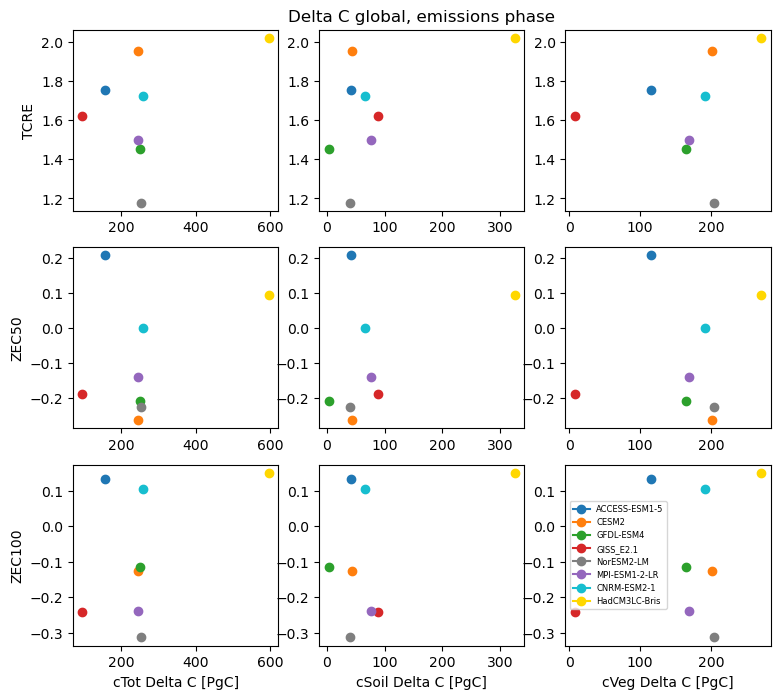

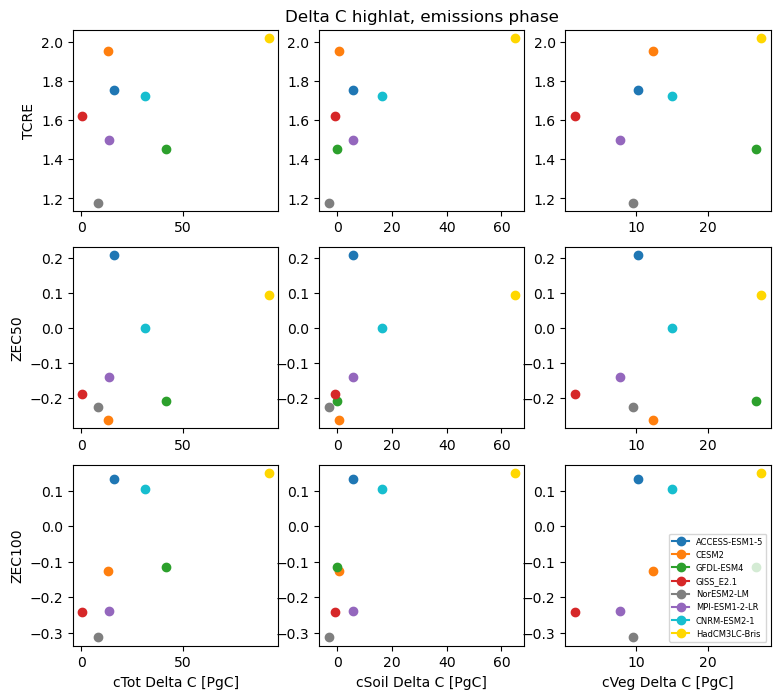

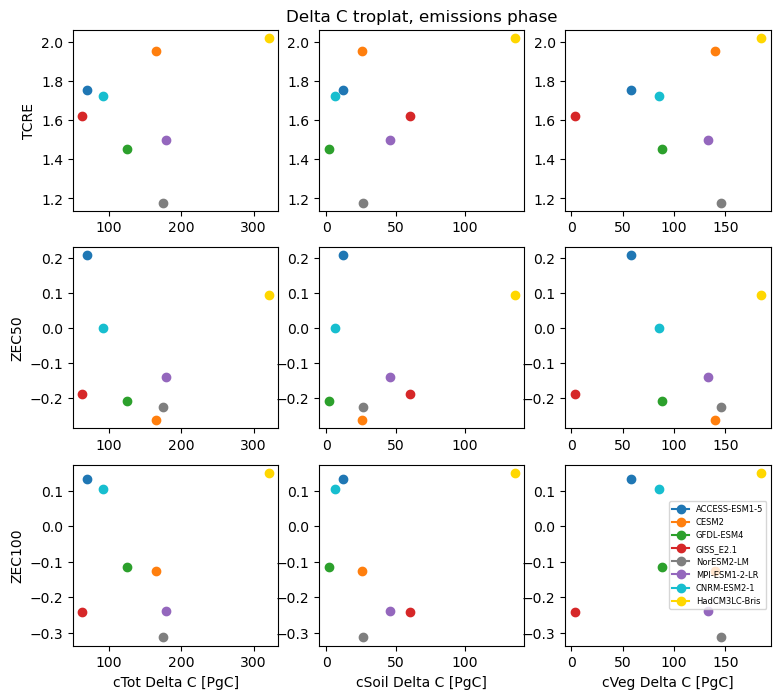

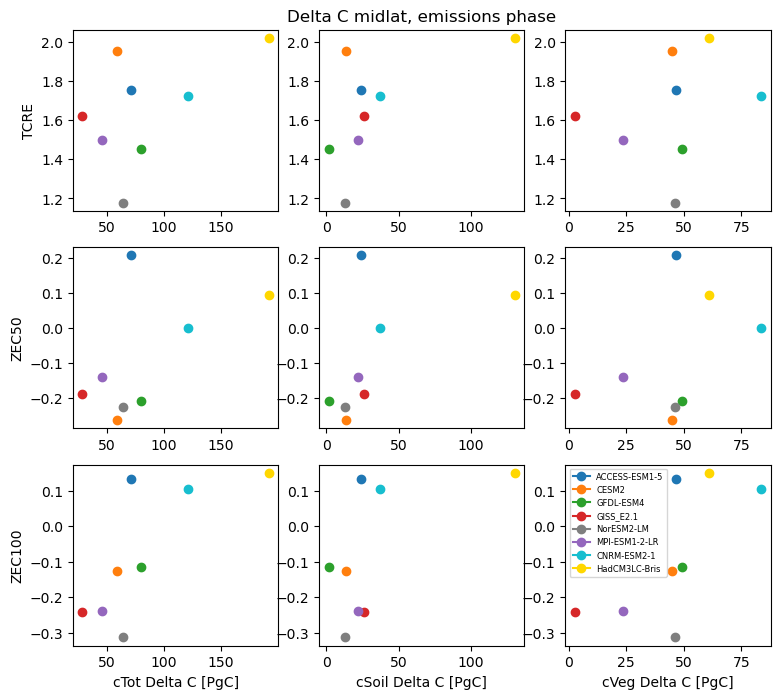

In [104]:

#axes=axes.flatten()

# rows are carbon variables, cTot, cVeg, cSoil
# columns are total change, % change
vlist = [2,1,0]
e=0

for l in range(len(latlist)):  
    fig, axes = plt.subplots(3,3,figsize=(9, 8))
    for m in range(len(modellist)):
        model=modellist[m]
        mcolor=modelcolors[m]
    
        tcre= esm_metrics_flat10['tcre'][il].values
        zec50=esm_metrics_flat10['zec50'][il].values
        zec100=esm_metrics_flat10['zec100'][il].values
        
        
        for vi in range(len(vlist)):
            v=vlist[vi]
            timeseries=ds_C_global.sel(model=modellist[m], run=runlist[e], 
                                           var=varlist[v], latrange=latlist[l])
            initC=np.mean(timeseries.data[0:9])
            nzC=np.mean(timeseries.data[90:109])
            deltaC=nzC-initC
            axes[0,vi].plot(deltaC,tcre[m],marker='o',label=model,color=mcolor)
            axes[0,vi].grid()
        
            axes[1,vi].plot(deltaC,zec50[m],marker='o',label=model,color=mcolor)
            axes[1,vi].grid()
        
            axes[2,vi].plot(deltaC,zec100[m],marker='o',label=model,color=mcolor)
            axes[2,vi].grid() 
        
    
    
    
    axes[0,1].set_title('Delta C ' +latlist[l] +', emissions phase')
    #axes[0,1].set_title(varlist[vlist[1]])
    #axes[0,2].set_title(varlist[vlist[2]])
    
    
    
    axes[2,0].set_xlabel(varlist[vlist[0]] +' Delta C [PgC]')
    axes[2,1].set_xlabel(varlist[vlist[1]] +' Delta C [PgC]')
    axes[2,2].set_xlabel(varlist[vlist[2]] +' Delta C [PgC]')
    
    
    axes[0,0].set_ylabel('TCRE')
    axes[1,0].set_ylabel('ZEC50')
    axes[2,0].set_ylabel('ZEC100')
    #axes[3,0].set_ylabel(var +'DeltaC at 1000PgC [%]')
    
    axes[2,2].legend(fontsize=6)
    
    plt.savefig("figures/TCRE_ZEC_scatter_" +latlist[l] +"_emissionsphase.pdf", bbox_inches='tight')
    plt.savefig("figures/TCRE_ZEC_scatter_" +latlist[l] +"_emissionsphase.png", bbox_inches='tight')


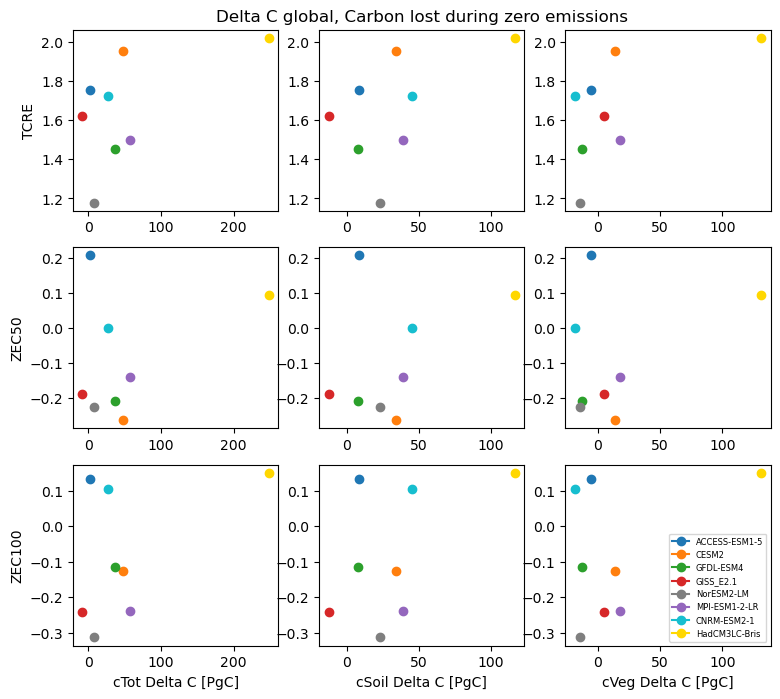

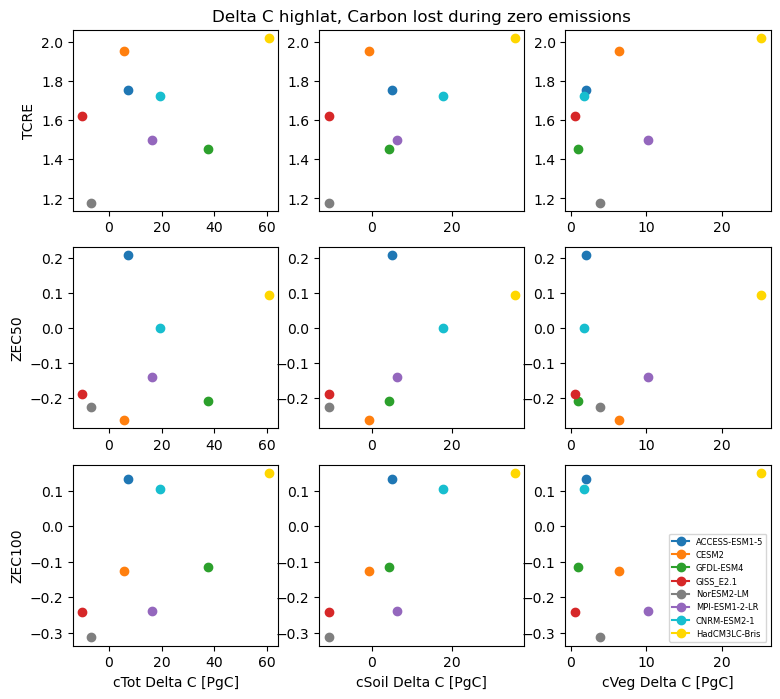

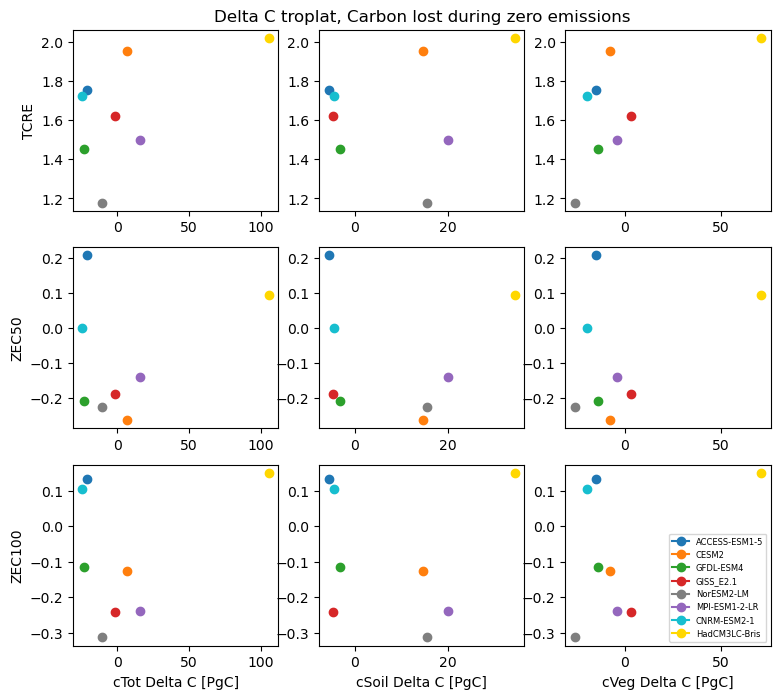

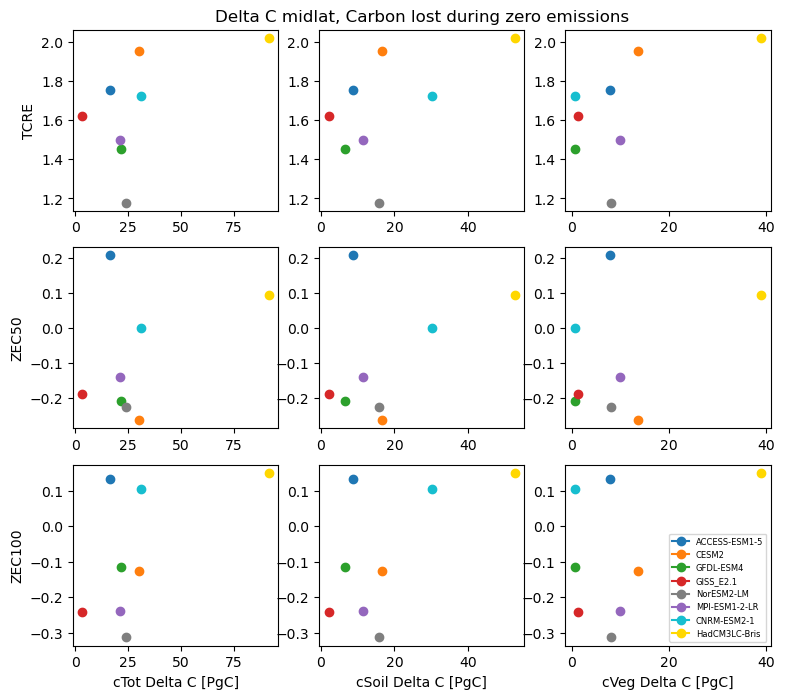

In [105]:

#axes=axes.flatten()

# rows are carbon variables, cTot, cVeg, cSoil
# columns are total change, % change
vlist = [2,1,0]
e=1

for l in range(len(latlist)):  
    fig, axes = plt.subplots(3,3,figsize=(9, 8))
    for m in range(len(modellist)):
        model=modellist[m]
        mcolor=modelcolors[m]
    
        tcre= esm_metrics_flat10['tcre'][il].values
        zec50=esm_metrics_flat10['zec50'][il].values
        zec100=esm_metrics_flat10['zec100'][il].values
        
        
        for vi in range(len(vlist)):
            v=vlist[vi]
            timeseries=ds_C_global.sel(model=modellist[m], run=runlist[e], 
                                           var=varlist[v], latrange=latlist[l])
            initC=np.mean(timeseries.data[0:9])
            nzC=np.mean(timeseries.data[190:199])
            deltaC=nzC-initC
            axes[0,vi].plot(deltaC,tcre[m],marker='o',label=model,color=mcolor)
            axes[0,vi].grid()
        
            axes[1,vi].plot(deltaC,zec50[m],marker='o',label=model,color=mcolor)
            axes[1,vi].grid()
        
            axes[2,vi].plot(deltaC,zec100[m],marker='o',label=model,color=mcolor)
            axes[2,vi].grid() 
        
    
    
    
    axes[0,1].set_title('Delta C ' +latlist[l] +', Carbon lost during zero emissions')
    #axes[0,1].set_title(varlist[vlist[1]])
    #axes[0,2].set_title(varlist[vlist[2]])
    
    
    
    axes[2,0].set_xlabel(varlist[vlist[0]] +' Delta C [PgC]')
    axes[2,1].set_xlabel(varlist[vlist[1]] +' Delta C [PgC]')
    axes[2,2].set_xlabel(varlist[vlist[2]] +' Delta C [PgC]')
    
    
    axes[0,0].set_ylabel('TCRE')
    axes[1,0].set_ylabel('ZEC50')
    axes[2,0].set_ylabel('ZEC100')
    #axes[3,0].set_ylabel(var +'DeltaC at 1000PgC [%]')
    
    axes[2,2].legend(fontsize=6)
    
    plt.savefig("figures/TCRE_ZEC_scatter_" +latlist[l] +"_zeroemissions.pdf", bbox_inches='tight')
    plt.savefig("figures/TCRE_ZEC_scatter_" +latlist[l] +"_zeroemissions.png", bbox_inches='tight')


### Full zonal profiles

Plotting ACCESS-ESM1-5


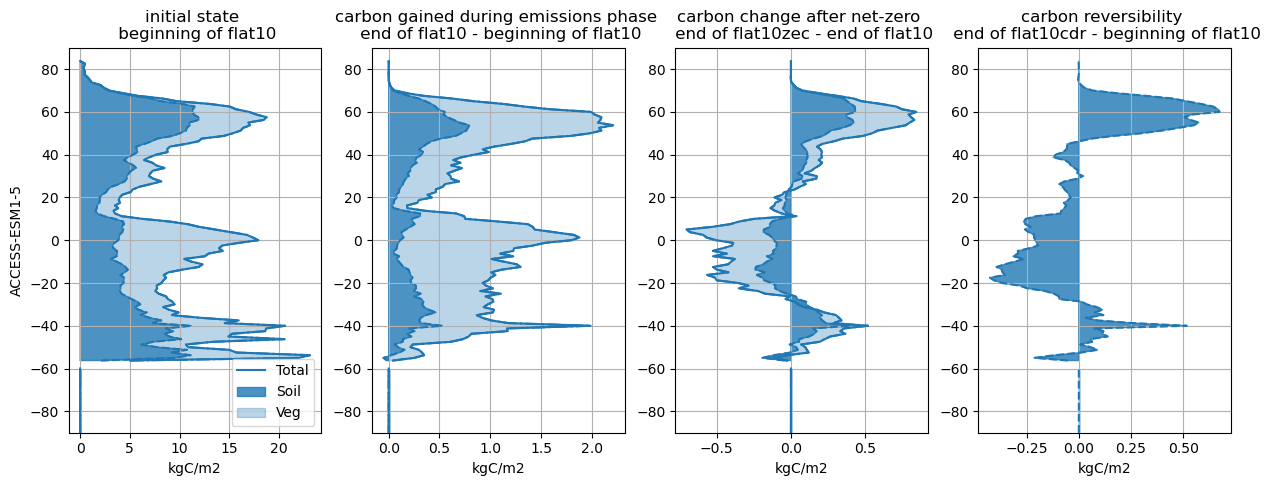

done saving file
Plotting CESM2


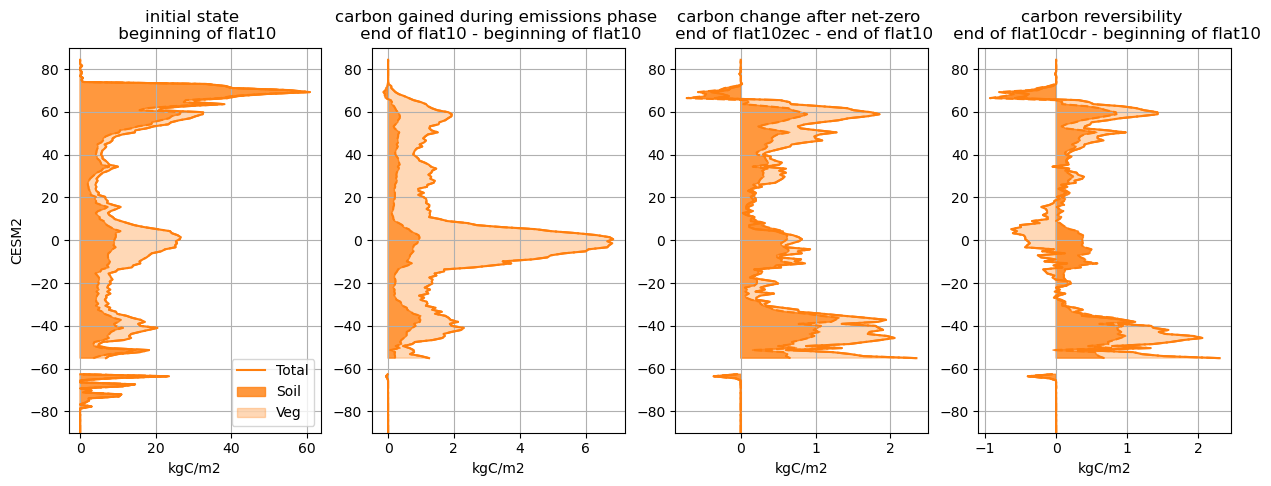

done saving file
Plotting GFDL-ESM4


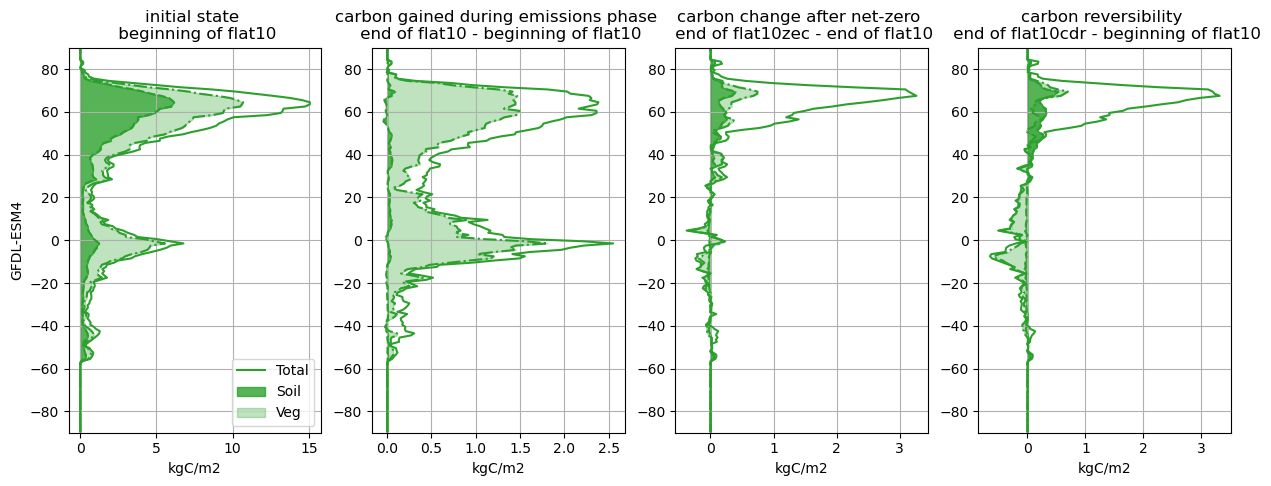

done saving file
Plotting GISS_E2.1


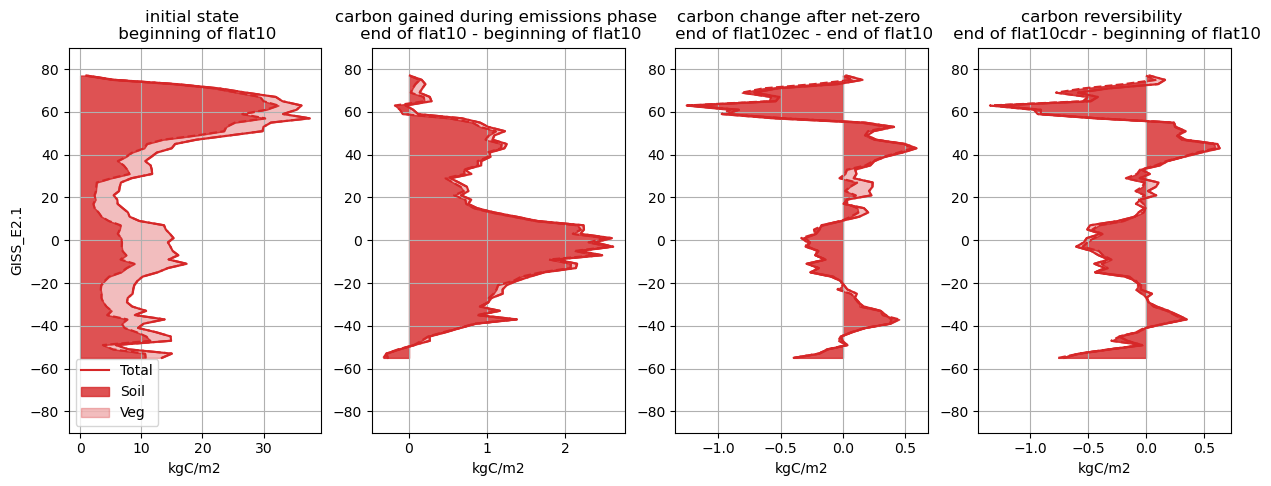

done saving file
Plotting NorESM2-LM


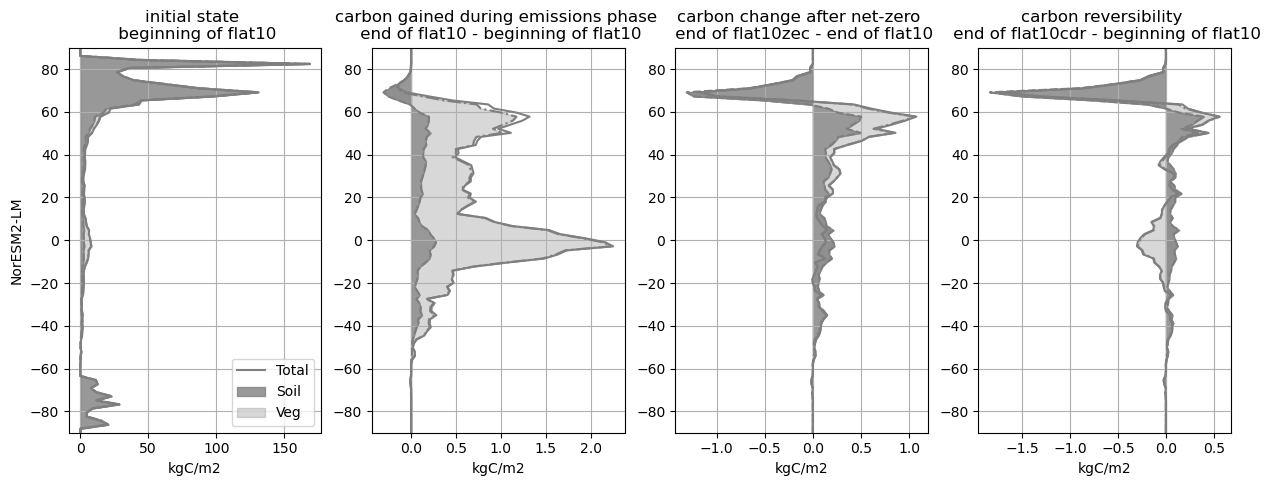

done saving file
Plotting MPI-ESM1-2-LR


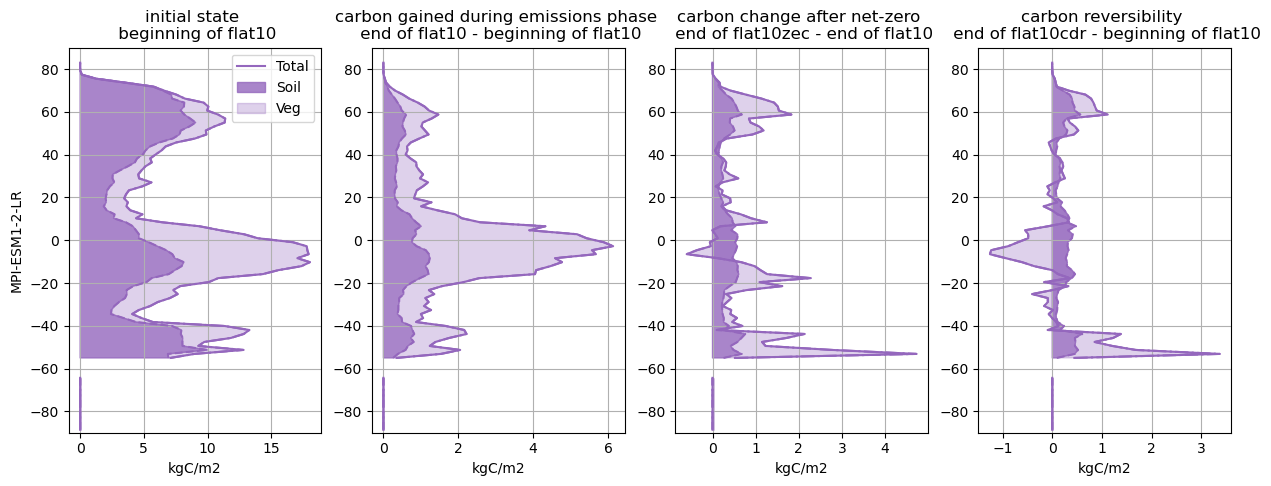

done saving file
Plotting CNRM-ESM2-1


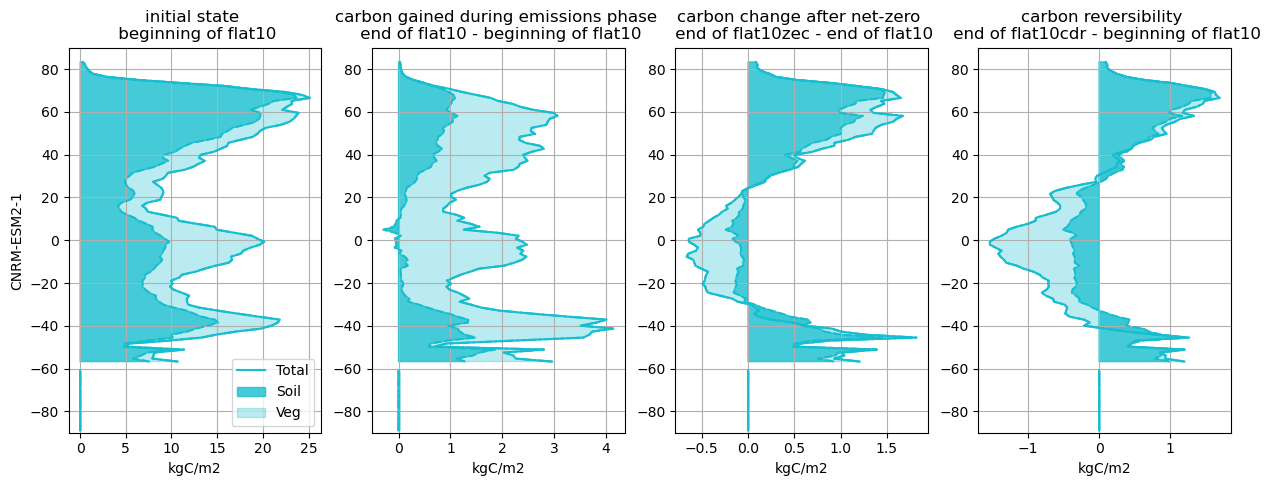

done saving file


In [388]:
# per area units

unitconvert=1
# zonal mean shaded plot, one plot for each model

# loop over models
for m in range(len(modellist)):
    model=modellist[m]
    print('Plotting ' +model)

    mcolor=modelcolors[m]

    # Create a figure and axis objects
    num_rows=1
    fig, axs = plt.subplots(num_rows, 4, figsize=(15, num_rows * 5))

    
    # create datasets for each model + experiment combination + variable
    # these are already subset to the correct time blocks
    
    ds0 = data_dict[modellist[m] +'_' +runlist[0]] #flat10
    ds1 = data_dict[modellist[m] +'_' +runlist[1]] #flat10-zec
    ds2 = data_dict[modellist[m] +'_' +runlist[2]] #flat10-cdr
    
    lat = ds0.lat
    
    #----###-----####----- cTot
    var='cTot'
    dsw=weighted_temporal_mean(ds0,var)*unitconvert
    dst= select_time_slice(dsw, 0, 9) # first ten years of flat10
    dsften_cTot = dst.mean(dim='lon').mean(dim='time')
    dst=select_time_slice(dsw, 90, 99) # last ten years of flat10
    dslten0_cTot = dst.mean(dim='lon').mean(dim='time')
    
    dsw=weighted_temporal_mean(ds1,var)*unitconvert
    dst = select_time_slice(dsw, 190, 199) #last ten years of flat10-zec
    dslten1_cTot = dst.mean(dim='lon').mean(dim='time')
    
    dsw=weighted_temporal_mean(ds2,var)*unitconvert
    dst = select_time_slice(dsw, 190, 199) # last ten years of flat10-cdr
    dslten2_cTot = dst.mean(dim='lon').mean(dim='time')
    
    
    #----###-----####----- cVeg
    var='cVeg'
    dsw=weighted_temporal_mean(ds0,var)*unitconvert
    dst= select_time_slice(dsw, 0, 9) # first ten years of flat10
    dsften_cVeg = dst.mean(dim='lon').mean(dim='time')
    dst=select_time_slice(dsw, 90, 99) # last ten years of flat10
    dslten0_cVeg = dst.mean(dim='lon').mean(dim='time')
    
    dsw=weighted_temporal_mean(ds1,var)*unitconvert
    dst = select_time_slice(dsw, 190, 199) #last ten years of flat10-zec
    dslten1_cVeg = dst.mean(dim='lon').mean(dim='time')
    
    dsw=weighted_temporal_mean(ds2,var)*unitconvert
    dst = select_time_slice(dsw, 190, 199) # last ten years of flat10-cdr
    dslten2_cVeg = dst.mean(dim='lon').mean(dim='time')
    
    
    #----###-----####----- cSoil
    var='cSoil'
    dsw=weighted_temporal_mean(ds0,var)*unitconvert
    dst= select_time_slice(dsw, 0, 9) # first ten years of flat10
    dsften_cSoil = dst.mean(dim='lon').mean(dim='time')
    dst=select_time_slice(dsw, 90, 99) # last ten years of flat10
    dslten0_cSoil = dst.mean(dim='lon').mean(dim='time')
    
    dsw=weighted_temporal_mean(ds1,var)*unitconvert
    dst = select_time_slice(dsw, 190, 199) #last ten years of flat10-zec
    dslten1_cSoil = dst.mean(dim='lon').mean(dim='time')
    
    dsw=weighted_temporal_mean(ds2,var)*unitconvert
    dst = select_time_slice(dsw, 190, 199) # last ten years of flat10-cdr
    dslten2_cSoil = dst.mean(dim='lon').mean(dim='time')
    
    
    #----###-----####----- cLitter
    var='cLitter'
    dsw=weighted_temporal_mean(ds0,var)*unitconvert
    dst= select_time_slice(dsw, 0, 9) # first ten years of flat10
    dsften_cLitter = dst.mean(dim='lon').mean(dim='time')
    dst=select_time_slice(dsw, 90, 99) # last ten years of flat10
    dslten0_cLitter = dst.mean(dim='lon').mean(dim='time')
    
    dsw=weighted_temporal_mean(ds1,var)*unitconvert
    dst = select_time_slice(dsw, 190, 199) #last ten years of flat10-zec
    dslten1_cLitter = dst.mean(dim='lon').mean(dim='time')
    
    dsw=weighted_temporal_mean(ds2,var)*unitconvert
    dst = select_time_slice(dsw, 190, 199) # last ten years of flat10-cdr
    dslten2_cLitter = dst.mean(dim='lon').mean(dim='time')
    ###----
    
    ###----------------------Plot-------------------------###
    
    


    # to use, refer to one index in axs: ax = axs[row, column]

    #---First column is flat10 climatology
    #--- first column is the climatology, or average of first 10 years 
    ax = axs[0] 

    # plot lines soil, veg + soil, total-litter, total
    dsften_cTot.plot(ax=ax,y='lat', linestyle='-',color=mcolor,label='Total')
    dsften_cSoil.plot(ax=ax,y='lat', linestyle='--',color=mcolor,label='_nolabel_')
    (dsften_cVeg+dsften_cSoil).plot(ax=ax,y='lat', linestyle='-.',color=mcolor,label='_nolabel_')
    #(dsften_cTot-dsften_cLitter).mean(dim='time').plot(ax=ax,y='lat',label=model, linestyle='.-',color=mcolor)

    # plot shaded area
    # soil, soil to veg
    #ax.fill_between(x, y_est - y_err, y_est + y_err, alpha=0.2)
    fg = ax.fill_betweenx(lat,0, dsften_cSoil,alpha=0.8,color=mcolor,label='Soil')
    fg2 = ax.fill_betweenx(lat,dsften_cSoil,dsften_cSoil+dsften_cVeg,alpha=0.3,color=mcolor,label='Veg')


    #--- Second column is end of flat10 emissions phase
    ax = axs[1]  
    #dsdelta=(dslten0.mean(dim='time')-dsften.mean(dim='time')).mean(dim='lon') #last 10 years of flat10 minus first ten years of flat10-zec
    #.plot(ax=ax,y='lat',label=model, linestyle='-',color=mcolor)


    # plot lines soil, veg + soil, total-litter, total
    (dslten0_cTot-dsften_cTot).plot(ax=ax,y='lat', linestyle='-',color=mcolor,label='Total')
    (dslten0_cSoil-dsften_cSoil).plot(ax=ax,y='lat', linestyle='--',color=mcolor,label='_nolabel_')
    ((dslten0_cVeg+dslten0_cSoil)-(dsften_cVeg+dsften_cSoil)).plot(ax=ax,y='lat', linestyle='-.',color=mcolor,label='_nolabel_')
    #(dsften_cTot-dsften_cLitter).mean(dim='time').plot(ax=ax,y='lat',label=model, linestyle='.-',color=mcolor)

    # plot shaded area
    # soil, soil to veg
    #ax.fill_between(x, y_est - y_err, y_est + y_err, alpha=0.2)
    fg = ax.fill_betweenx(lat,0, dslten0_cSoil-dsften_cSoil,alpha=0.8,color=mcolor,label='Soil')
    fg2 = ax.fill_betweenx(lat,dslten0_cSoil-dsften_cSoil,(dslten0_cSoil-dsften_cSoil)+(dslten0_cVeg-dsften_cVeg),alpha=0.3,color=mcolor,label='Veg')

    #--- Third column is end of flat10zec phase
    ax = axs[2] 
    #dsdelta=dslten1.mean(dim='time')-dslten0.mean(dim='time') #last 10 years of flat10-zec minus last 10 years of flat10
    #fg = dsdelta.mean(dim='lon').plot(ax=ax,y='lat',label=model, linestyle='-',color=mcolor) 

    # plot lines soil, veg + soil, total-litter, total
    (dslten1_cTot-dslten0_cTot).plot(ax=ax,y='lat', linestyle='-',color=mcolor,label='Total')
    (dslten1_cSoil-dslten0_cSoil).plot(ax=ax,y='lat', linestyle='--',color=mcolor,label='_nolabel_')
    ((dslten1_cVeg+dslten1_cSoil)-(dslten0_cVeg+dslten0_cSoil)).plot(ax=ax,y='lat', linestyle='-.',color=mcolor,label='_nolabel_')
    #(dsften_cTot-dsften_cLitter).mean(dim='time').plot(ax=ax,y='lat',label=model, linestyle='.-',color=mcolor)

    # plot shaded area
    # soil, soil to veg
    #ax.fill_between(x, y_est - y_err, y_est + y_err, alpha=0.2)
    fg = ax.fill_betweenx(lat,0, dslten1_cSoil-dslten0_cSoil,alpha=0.8,color=mcolor,label='Soil')
    fg2 = ax.fill_betweenx(lat,dslten1_cSoil-dslten0_cSoil,(dslten1_cSoil-dslten0_cSoil)+(dslten1_cVeg-dslten0_cVeg),alpha=0.3,color=mcolor,label='Veg')

    #--- Fourth column is end of flat10cdr phase

    ax = axs[3] 

    #dsdelta=dslten2.mean(dim='time')-dsften.mean(dim='time') #last 10 years of flat10-cdr minus first ten years of flat10
    #fg = dsdelta.mean(dim='lon').plot(ax=ax,y='lat',label=model, linestyle='-',color=mcolor) 


    # plot lines soil, veg + soil, total-litter, total
    (dslten2_cTot-dsften_cTot).plot(ax=ax,y='lat', linestyle='-',color=mcolor,label='Total')
    (dslten2_cSoil-dsften_cSoil).plot(ax=ax,y='lat', linestyle='--',color=mcolor,label='_nolabel_')
    ((dslten2_cVeg+dslten2_cSoil)-(dsften_cVeg+dsften_cSoil)).plot(ax=ax,y='lat', linestyle='-.',color=mcolor,label='_nolabel_')
    #(dsften_cTot-dsften_cLitter).mean(dim='time').plot(ax=ax,y='lat',label=model, linestyle='.-',color=mcolor)

    # plot shaded area
    # soil, soil to veg
    #ax.fill_between(x, y_est - y_err, y_est + y_err, alpha=0.2)
    fg = ax.fill_betweenx(lat,0, dslten2_cSoil-dsften_cSoil,alpha=0.8,color=mcolor,label='Soil')
    fg2 = ax.fill_betweenx(lat,dslten2_cSoil-dsften_cSoil,(dslten2_cSoil-dsften_cSoil)+(dslten2_cVeg-dsften_cVeg),alpha=0.3,color=mcolor,label='Veg')


    #-- try setting some properties after the loop through models
    ax=axs[0]
    ax.set_ylim([-90, 90])
    ax.grid(True)
    ax.set_ylabel(model)
    ax.set_xlabel('kgC/m2')
    ax.legend()
    
    ax=axs[1]
    ax.set_ylim([-90, 90])
    ax.grid(True)
    ax.set_xlabel('kgC/m2')
    ax.set_ylabel('')
    
    ax=axs[2]
    ax.set_ylim([-90, 90])
    ax.grid(True)
    ax.set_xlabel('kgC/m2')
    ax.set_ylabel('')
    
    ax=axs[3]
    ax.set_ylim([-90, 90])
    ax.grid(True)
    ax.set_xlabel('kgC/m2')
    ax.set_ylabel('')
    

    # set titles for top row of plots
    ax=axs[0]
    ax.set_title('initial state \n beginning of flat10')
    
    ax=axs[1]
    ax.set_title('carbon gained during emissions phase \n end of flat10 - beginning of flat10')
    
    ax=axs[2]
    ax.set_title('carbon change after net-zero \n end of flat10zec - end of flat10')
    
    ax=axs[3]
    ax.set_title('carbon reversibility \n end of flat10cdr - beginning of flat10')
    
    
    
    
    # show the plot:
    plt.show()
    
    # save the plot
    fig.savefig('figures/' +'Cdelta_zonal_lineplot_' +model +'.png', bbox_inches='tight', dpi=1200)
    
    print('done saving file')
    
    # close the plot (so python stops trying to hold on to it in memory; you can
    # still look at it at this point, but you're done editing)
    plt.close()


Plotting ACCESS-ESM1-5


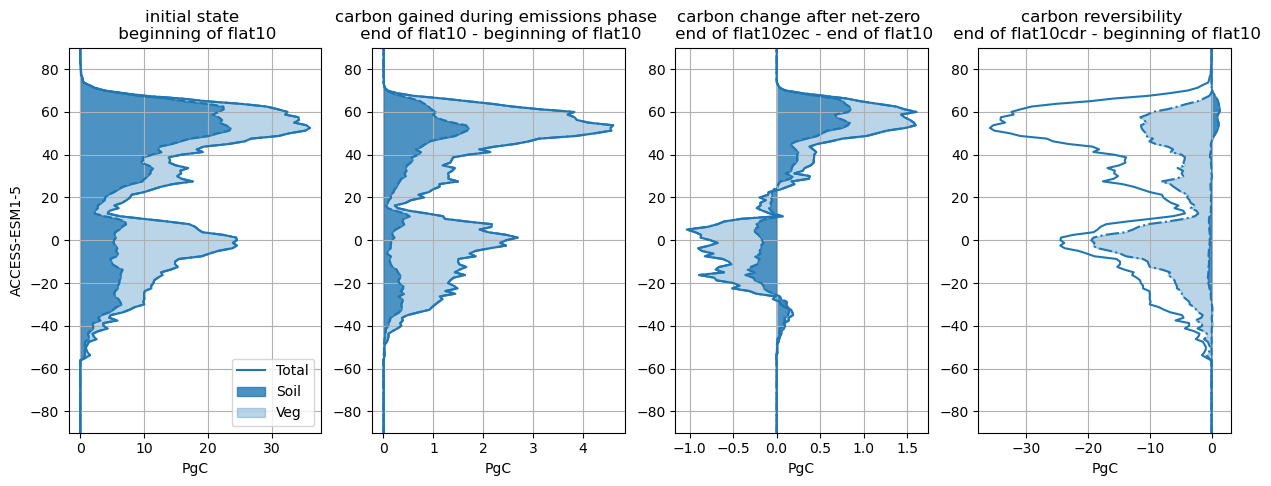

done saving file
Plotting CESM2


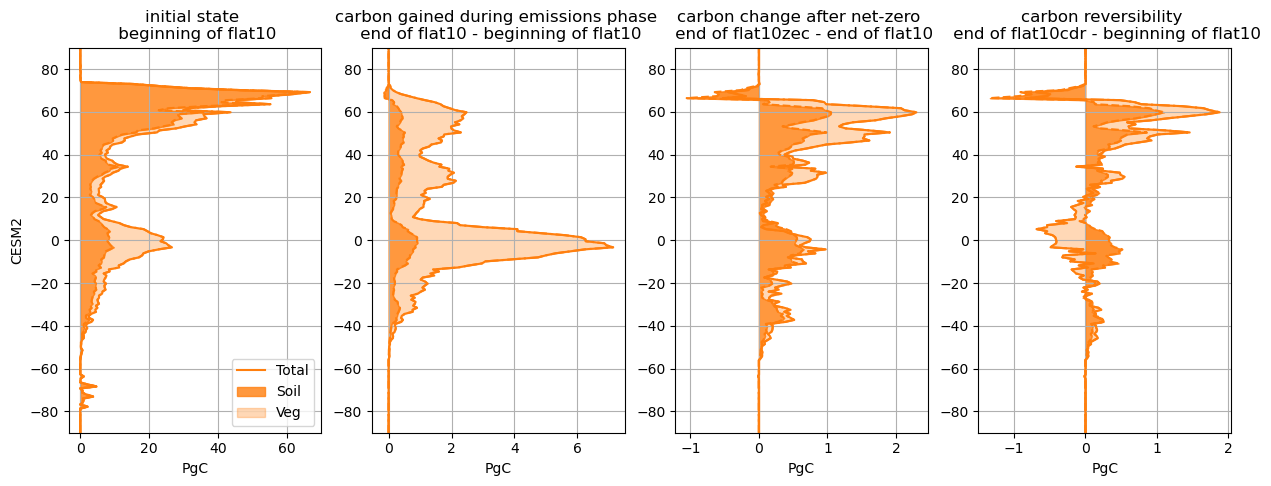

done saving file
Plotting GFDL-ESM4


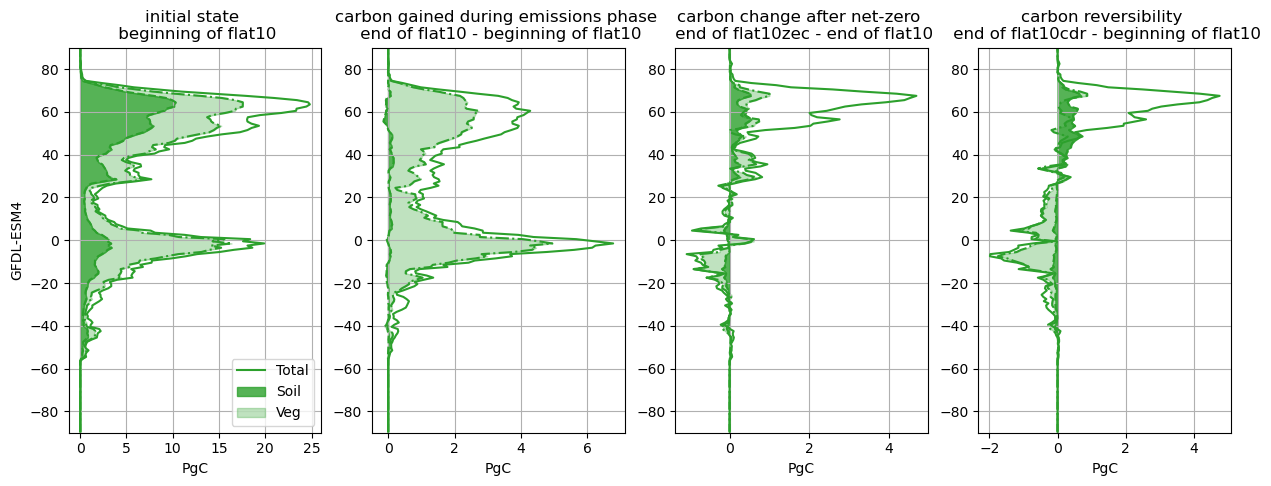

done saving file
Plotting GISS_E2.1


ValueError: x and y must have same first dimension, but have shapes (88,) and (90,)

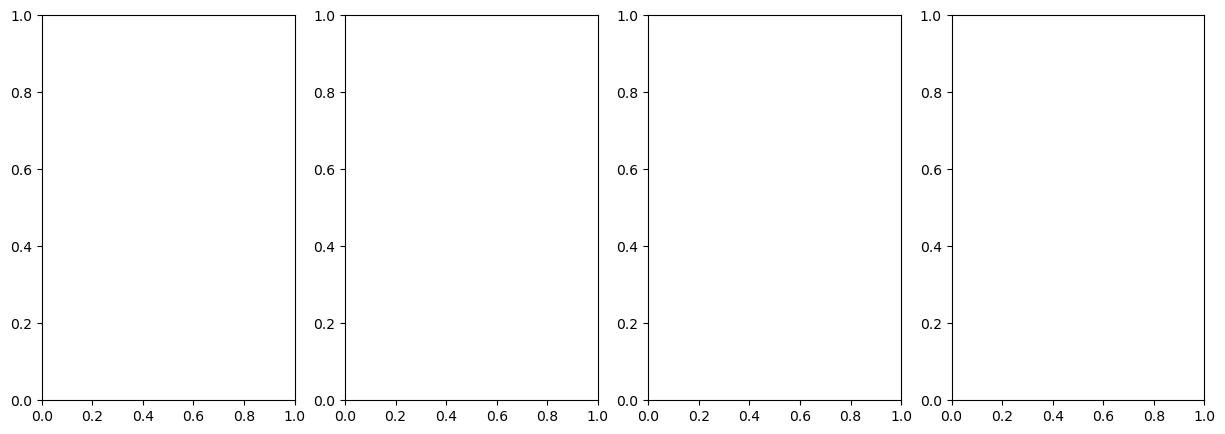

In [418]:
# total carbon units (not area weighted)

unitconvert=1e-12
# zonal mean shaded plot, one plot for each model

# loop over models
for m in range(len(modellist)):
    model=modellist[m]
    print('Plotting ' +model)

    mcolor=modelcolors[m]

    # Create a figure and axis objects
    num_rows=1
    fig, axs = plt.subplots(num_rows, 4, figsize=(15, num_rows * 5))

    
    # create datasets for each model + experiment combination + variable
    # these are already subset to the correct time blocks
    
    ds0 = data_dict[modellist[m] +'_' +runlist[0]] #flat10
    ds1 = data_dict[modellist[m] +'_' +runlist[1]] #flat10-zec
    ds2 = data_dict[modellist[m] +'_' +runlist[2]] #flat10-cdr
    
    lat = ds0.lat

    #--- get area and land fraction
    ds_area = data_dict[modellist[m] +'_' +'areacella']
    ds_landfrac = data_dict[modellist[m] +'_' +'landfrac']
    
    if model=='CESM2':
        area = ds_area['areacella'].squeeze().reindex_like(ds0, method='nearest',tolerance=0.05)
    elif model=='GISS_E2.1':
        area_vec = ds_area['areacella'][:,-1]
        area,lf = xr.broadcast(area_vec,ds_landfrac['sftlf'])
    else:
        area = ds_area['areacella'].reindex_like(ds0, method='nearest',tolerance=0.05)
    
    landfrac=ds_landfrac['sftlf'].reindex_like(ds0, method='nearest',tolerance=0.05)
    
    if landfrac.max(dim=['lat','lon'])>1: #test if landfrac is on a 0-100 or 0-1 scale
        landfrac=landfrac/100
        
    landarea=(area*landfrac)
    area_per_lat_m2=(area*landfrac).sum(dim='lon')
    
    #----###-----####----- cTot
    var='cTot'
    dsw=weighted_temporal_mean(ds0,var)*unitconvert
    dst= select_time_slice(dsw, 0, 9) # first ten years of flat10
    dsften_cTot = (dst*landarea).sum(dim='lon').mean(dim='time')
    dst=select_time_slice(dsw, 90, 99) # last ten years of flat10
    dslten0_cTot = (dst*landarea).sum(dim='lon').mean(dim='time')
    
    dsw=weighted_temporal_mean(ds1,var)*unitconvert
    dst = select_time_slice(dsw, 190, 199) #last ten years of flat10-zec
    dslten1_cTot = (dst*landarea).sum(dim='lon').mean(dim='time')
    
    dsw=weighted_temporal_mean(ds2,var)*unitconvert
    dst = select_time_slice(dsw, 190, 199) # last ten years of flat10-cdr
    dslten2_cTot = (dst*landarea).sum(dim='lon').mean(dim='time')
    
    
    #----###-----####----- cVeg
    var='cVeg'
    dsw=weighted_temporal_mean(ds0,var)*unitconvert
    dst= select_time_slice(dsw, 0, 9) # first ten years of flat10
    dsften_cVeg = (dst*landarea).sum(dim='lon').mean(dim='time')
    dst=select_time_slice(dsw, 90, 99) # last ten years of flat10
    dslten0_cVeg = (dst*landarea).sum(dim='lon').mean(dim='time')
    
    dsw=weighted_temporal_mean(ds1,var)*unitconvert
    dst = select_time_slice(dsw, 190, 199) #last ten years of flat10-zec
    dslten1_cVeg = (dst*landarea).sum(dim='lon').mean(dim='time')
    
    dsw=weighted_temporal_mean(ds2,var)*unitconvert
    dst = select_time_slice(dsw, 190, 199) # last ten years of flat10-cdr
    dslten2_cVeg = (dst*landarea).sum(dim='lon').mean(dim='time')
    
    
    #----###-----####----- cSoil
    var='cSoil'
    dsw=weighted_temporal_mean(ds0,var)*unitconvert
    dst= select_time_slice(dsw, 0, 9) # first ten years of flat10
    dsften_cSoil = (dst*landarea).sum(dim='lon').mean(dim='time')
    dst=select_time_slice(dsw, 90, 99) # last ten years of flat10
    dslten0_cSoil = (dst*landarea).sum(dim='lon').mean(dim='time')
    
    dsw=weighted_temporal_mean(ds1,var)*unitconvert
    dst = select_time_slice(dsw, 190, 199) #last ten years of flat10-zec
    dslten1_cSoil = (dst*landarea).sum(dim='lon').mean(dim='time')
    
    dsw=weighted_temporal_mean(ds2,var)*unitconvert
    dst = select_time_slice(dsw, 190, 199) # last ten years of flat10-cdr
    dslten2_cSoil = (dst*landarea).sum(dim='lon').mean(dim='time')
    
    
    #----###-----####----- cLitter
    var='cLitter'
    dsw=weighted_temporal_mean(ds0,var)*unitconvert
    dst= select_time_slice(dsw, 0, 9) # first ten years of flat10
    dsften_cLitter = (dst*landarea).sum(dim='lon').mean(dim='time')
    dst=select_time_slice(dsw, 90, 99) # last ten years of flat10
    dslten0_cLitter = (dst*landarea).sum(dim='lon').mean(dim='time')
    
    dsw=weighted_temporal_mean(ds1,var)*unitconvert
    dst = select_time_slice(dsw, 190, 199) #last ten years of flat10-zec
    dslten1_cLitter = (dst*landarea).sum(dim='lon').mean(dim='time')
    
    dsw=weighted_temporal_mean(ds2,var)*unitconvert
    dst = select_time_slice(dsw, 190, 199) # last ten years of flat10-cdr
    dslten2_cLitter = (dst*landarea).sum(dim='lon').mean(dim='time')
    ###----
    
    ###----------------------Plot-------------------------###
    
    


    # to use, refer to one index in axs: ax = axs[row, column]

    #---First column is flat10 climatology
    #--- first column is the climatology, or average of first 10 years 
    ax = axs[0] 

    # plot lines soil, veg + soil, total-litter, total
#    dsften_cTot.plot(ax=ax,y='lat', linestyle='-',color=mcolor,label='Total')
#    dsften_cSoil.plot(ax=ax,y='lat', linestyle='--',color=mcolor,label='_nolabel_')
#    (dsften_cVeg+dsften_cSoil).plot(ax=ax,y='lat', linestyle='-.',color=mcolor,label='_nolabel_')
    #(dsften_cTot-dsften_cLitter).mean(dim='time').plot(ax=ax,y='lat',label=model, linestyle='.-',color=mcolor)

    ax.plot(dsften_cTot,lat, linestyle='-',color=mcolor,label='Total')
    ax.plot(dsften_cSoil,lat, linestyle='--',color=mcolor,label='_nolabel_')
    ax.plot((dsften_cVeg+dsften_cSoil),lat, linestyle='-.',color=mcolor,label='_nolabel_')

    # plot shaded area
    # soil, soil to veg
    #ax.fill_between(x, y_est - y_err, y_est + y_err, alpha=0.2)
    fg = ax.fill_betweenx(lat,0, dsften_cSoil,alpha=0.8,color=mcolor,label='Soil')
    fg2 = ax.fill_betweenx(lat,dsften_cSoil,dsften_cSoil+dsften_cVeg,alpha=0.3,color=mcolor,label='Veg')


    #--- Second column is end of flat10 emissions phase
    ax = axs[1]  
    #dsdelta=(dslten0.mean(dim='time')-dsften.mean(dim='time')).mean(dim='lon') #last 10 years of flat10 minus first ten years of flat10-zec
    #.plot(ax=ax,y='lat',label=model, linestyle='-',color=mcolor)


    # plot lines soil, veg + soil, total-litter, total
    (dslten0_cTot-dsften_cTot).plot(ax=ax,y='lat', linestyle='-',color=mcolor,label='Total')
    (dslten0_cSoil-dsften_cSoil).plot(ax=ax,y='lat', linestyle='--',color=mcolor,label='_nolabel_')
    ((dslten0_cVeg+dslten0_cSoil)-(dsften_cVeg+dsften_cSoil)).plot(ax=ax,y='lat', linestyle='-.',color=mcolor,label='_nolabel_')
    #(dsften_cTot-dsften_cLitter).mean(dim='time').plot(ax=ax,y='lat',label=model, linestyle='.-',color=mcolor)

    # plot shaded area
    # soil, soil to veg
    #ax.fill_between(x, y_est - y_err, y_est + y_err, alpha=0.2)
    fg = ax.fill_betweenx(lat,0, dslten0_cSoil-dsften_cSoil,alpha=0.8,color=mcolor,label='Soil')
    fg2 = ax.fill_betweenx(lat,dslten0_cSoil-dsften_cSoil,(dslten0_cSoil-dsften_cSoil)+(dslten0_cVeg-dsften_cVeg),alpha=0.3,color=mcolor,label='Veg')

    #--- Third column is end of flat10zec phase
    ax = axs[2] 
    #dsdelta=dslten1.mean(dim='time')-dslten0.mean(dim='time') #last 10 years of flat10-zec minus last 10 years of flat10
    #fg = dsdelta.mean(dim='lon').plot(ax=ax,y='lat',label=model, linestyle='-',color=mcolor) 

    # plot lines soil, veg + soil, total-litter, total
    (dslten1_cTot-dslten0_cTot).plot(ax=ax,y='lat', linestyle='-',color=mcolor,label='Total')
    (dslten1_cSoil-dslten0_cSoil).plot(ax=ax,y='lat', linestyle='--',color=mcolor,label='_nolabel_')
    ((dslten1_cVeg+dslten1_cSoil)-(dslten0_cVeg+dslten0_cSoil)).plot(ax=ax,y='lat', linestyle='-.',color=mcolor,label='_nolabel_')
    #(dsften_cTot-dsften_cLitter).mean(dim='time').plot(ax=ax,y='lat',label=model, linestyle='.-',color=mcolor)

    # plot shaded area
    # soil, soil to veg
    #ax.fill_between(x, y_est - y_err, y_est + y_err, alpha=0.2)
    fg = ax.fill_betweenx(lat,0, dslten1_cSoil-dslten0_cSoil,alpha=0.8,color=mcolor,label='Soil')
    fg2 = ax.fill_betweenx(lat,dslten1_cSoil-dslten0_cSoil,(dslten1_cSoil-dslten0_cSoil)+(dslten1_cVeg-dslten0_cVeg),alpha=0.3,color=mcolor,label='Veg')

    #--- Fourth column is end of flat10cdr phase

    ax = axs[3] 

    #dsdelta=dslten2.mean(dim='time')-dsften.mean(dim='time') #last 10 years of flat10-cdr minus first ten years of flat10
    #fg = dsdelta.mean(dim='lon').plot(ax=ax,y='lat',label=model, linestyle='-',color=mcolor) 


    # plot lines soil, veg + soil, total-litter, total
    (dslten2_cTot-dsften_cTot).plot(ax=ax,y='lat', linestyle='-',color=mcolor,label='Total')
    (dslten2_cSoil-dsften_cSoil).plot(ax=ax,y='lat', linestyle='--',color=mcolor,label='_nolabel_')
    ((dslten2_cVeg+dslten2_cSoil)-(dsften_cVeg+dsften_cSoil)).plot(ax=ax,y='lat', linestyle='-.',color=mcolor,label='_nolabel_')
    #(dsften_cTot-dsften_cLitter).mean(dim='time').plot(ax=ax,y='lat',label=model, linestyle='.-',color=mcolor)
    
    # plot shaded area
    # soil, soil to veg
    #ax.fill_between(x, y_est - y_err, y_est + y_err, alpha=0.2)
    fg = ax.fill_betweenx(lat,0, dslten2_cSoil-dsften_cSoil,alpha=0.8,color=mcolor,label='Soil')
    fg2 = ax.fill_betweenx(lat,dslten2_cSoil-dsften_cSoil,(dslten2_cSoil-dsften_cSoil)+(dslten2_cVeg-dsften_cVeg),alpha=0.3,color=mcolor,label='Veg')


    #-- try setting some properties after the loop through models
    ax=axs[0]
    ax.set_ylim([-90, 90])
    ax.grid(True)
    ax.set_ylabel(model)
    ax.set_xlabel('PgC')
    ax.legend()
    
    ax=axs[1]
    ax.set_ylim([-90, 90])
    ax.grid(True)
    ax.set_xlabel('PgC')
    ax.set_ylabel('')
    
    ax=axs[2]
    ax.set_ylim([-90, 90])
    ax.grid(True)
    ax.set_xlabel('PgC')
    ax.set_ylabel('')
    
    ax=axs[3]
    ax.set_ylim([-90, 90])
    ax.grid(True)
    ax.set_xlabel('PgC')
    ax.set_ylabel('')
    

    # set titles for top row of plots
    ax=axs[0]
    ax.set_title('initial state \n beginning of flat10')
    
    ax=axs[1]
    ax.set_title('carbon gained during emissions phase \n end of flat10 - beginning of flat10')
    
    ax=axs[2]
    ax.set_title('carbon change after net-zero \n end of flat10zec - end of flat10')
    
    ax=axs[3]
    ax.set_title('carbon reversibility \n end of flat10cdr - beginning of flat10')
    
    
    
    
    # show the plot:
    plt.show()
    
    # save the plot
    fig.savefig('figures/' +'Cdelta_zonal_lineplot_' +model +'_PgC.png', bbox_inches='tight', dpi=1200)
    
    print('done saving file')
    
    # close the plot (so python stops trying to hold on to it in memory; you can
    # still look at it at this point, but you're done editing)
    plt.close()


In [ ]:
def plot_zonal_delta_multiplevariables_flux_annmean(var, modellist,unitconvert):
    """
    Plots an array of zonal profiles over time with one line for each model
    
    Args:
    - modellist: a list of model names for which data is contained in data_dict
    - var: the name of the variable to plot
    
    Returns:
    - a figure with an array of zonal line plots. First panel is climatology beginning
    of flat10, second is end of flat10, third end of flat10zec, fourth end of flat10cdr
    """   
   

    # --set up the subplots
    # Calculate the number of rows
    #num_rows = (len(modellist)*3 + 2) // 3  # Ceiling division to ensure we have enough rows

    # in this case we won't have one row per model, because we can have all models on one plot
    # so make one row per variable
    num_rows=1
    
    # Create a figure and axis objects
    fig, axs = plt.subplots(num_rows, 4, figsize=(15, num_rows * 5))
    
    # Flatten the axis array to iterate easily
    #axs = axs.flatten()
    # to use, refer to one index in axs: ax = axs[i]
        
    
    # loop over models
    for m in range(len(modellist)):
        model=modellist[m]
        print('Plotting ' +model)

        if m>10:
            linestyle='--'
        else:
            linestyle='-'

        mcolor=modelcolors[m]
        
        # create datasets for each model + experiment combination + variable
        # these are already subset to the correct time blocks
        
        ds0 = data_dict[modellist[m] +'_' +runlist[0]] #flat10
        ds1 = data_dict[modellist[m] +'_' +runlist[1]] #flat10-zec
        ds2 = data_dict[modellist[m] +'_' +runlist[2]] #flat10-cdr
        
        dsw=weighted_temporal_mean(ds0,var)*unitconvert
        dsften = select_time_slice(dsw, 0, 9) # first ten years of flat10
        dslten0 = select_time_slice(dsw, 90, 99) # last ten years of flat10

        dsw=weighted_temporal_mean(ds1,var)*unitconvert
        dslten1 = select_time_slice(dsw, 190, 199) #last ten years of flat10-zec

        dsw=weighted_temporal_mean(ds2,var)*unitconvert
        dslten2 = select_time_slice(dsw, 190, 199) # last ten years of flat10-cdr

        #-- now plot
        
        #---First column is flat10 climatology
        
        
        #--- first column is the climatology, or average of first 10 years 
        ax = axs[0] 

        #find average of first 10 years of flat10
        fg = (dsften).mean(dim='lon').mean(dim='time').plot(ax=ax,y='lat',label=model, linestyle=linestyle,color=mcolor) #cmap='PiYG', #x='time',add_colorbar=False,
        
        #ax.set_ylabel(model)
        plt.ylim([-90, 90])
        ax.grid(True)
        
        # if it is the first model, label the plot
        if m==0:
            plt.title('Pre-industrial')
        
        
        #--- Second column is end of flat10 emissions phase
        ax = axs[1] 
        dsdelta=dslten0.mean(dim='time')-dsften.mean(dim='time') #last 10 years of flat10 minus first ten years of flat10-zec
        fg = dsdelta.mean(dim='lon').plot(ax=ax,y='lat',label=model, linestyle=linestyle,color=mcolor) #cmap='PiYG', #x='time',

        ax.set_ylabel('')
        plt.ylim([-90, 90])
        ax.grid(True)
    
        if m==0:
            plt.title('end of flat10')
        
        #--- Third column is end of flat10zec phase
        
        
        ax = axs[2] 
        dsdelta=dslten1.mean(dim='time')-dslten0.mean(dim='time') #last 10 years of flat10-zec minus last 10 years of flat10
        fg = dsdelta.mean(dim='lon').plot(ax=ax,y='lat',label=model, linestyle=linestyle,color=mcolor) #cmap='PiYG', #x='time',
        
        ax.set_ylabel('')
        plt.ylim([-90, 90])
        ax.grid(True)
    
        if m==0:
            plt.title('end of flat10zec')
        
         #--- Fourth column is end of flat10cdr phase
        
        ax = axs[3] 
        
        dsdelta=dslten2.mean(dim='time')-dsften.mean(dim='time') #last 10 years of flat10-cdr minus first ten years of flat10
        fg = dsdelta.mean(dim='lon').plot(ax=ax,y='lat',label=model, linestyle=linestyle,color=mcolor) #cmap='PiYG', #x='time',
        
        ax.set_ylabel('')
        plt.ylim([-90, 90])
        ax.grid(True)
    
        if m==0:
            plt.title('end of flat10cdr')

        
        fig.suptitle(var)
    



    #-- try setting some properties after the loop through models
    ax=axs[0]
    ax.set_ylim([-90, 90])
    ax.grid(True)
    ax.set_ylabel('Latitude')
    ax.set_title('initial state \n beginning of flat10')
    ax.legend()
    

    ax=axs[1]
    ax.set_ylim([-90, 90])
    ax.grid(True)
    ax.set_ylabel('')
    ax.set_title('carbon gained during emissions phase \n end of flat10 - beginning of flat10')

    ax=axs[2]
    ax.set_ylim([-90, 90])
    ax.grid(True)
    ax.set_ylabel('')
    ax.set_title('carbon change after net-zero \n end of flat10zec - end of flat10')

    ax=axs[3]
    ax.set_ylim([-90, 90])
    ax.grid(True)
    ax.set_ylabel('')
    ax.set_title('carbon reversibility \n end of flat10cdr - beginning of flat10')


    
    # show the plot:
    plt.show()
    
    # save the plot
    fig.savefig('figures/' +var +'_delta_zonal_lineplot.png', bbox_inches='tight', dpi=1200)
    
    print('done saving file')
    
    # close the plot (so python stops trying to hold on to it in memory; you can
    # still look at it at this point, but you're done editing)
    plt.close()

# Testing

# #---------# Snippets below #-----------#

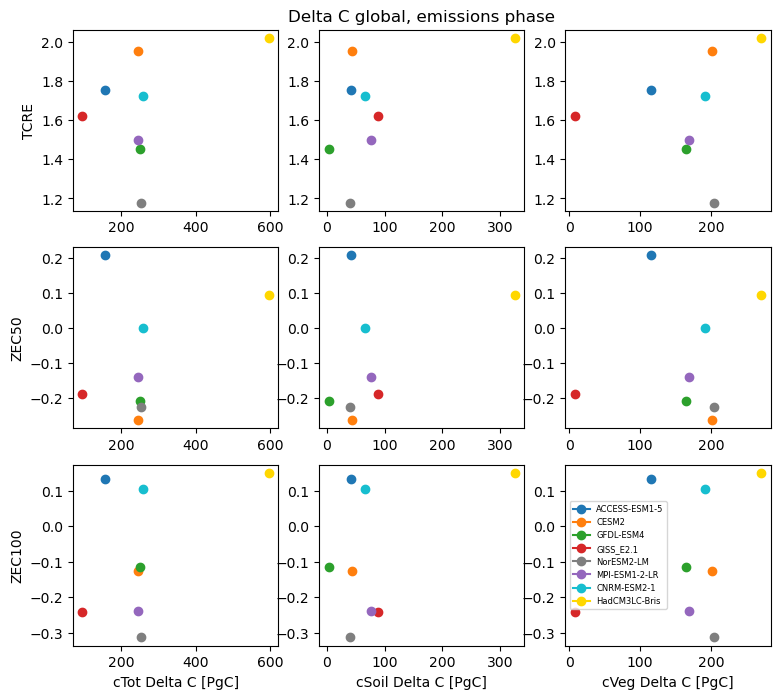

In [101]:
fig, axes = plt.subplots(3,3,figsize=(9, 8))
#axes=axes.flatten()

# rows are carbon variables, cTot, cVeg, cSoil
# columns are total change, % change
vlist = [2,1,0]
e=0
l=0

for m in range(len(modellist)):
    model=modellist[m]
    mcolor=modelcolors[m]

    tcre= esm_metrics_flat10['tcre'][il].values
    zec50=esm_metrics_flat10['zec50'][il].values
    zec100=esm_metrics_flat10['zec100'][il].values
    
    
    for vi in range(len(vlist)):
        v=vlist[vi]
        timeseries=ds_C_global.sel(model=modellist[m], run=runlist[e], 
                                       var=varlist[v], latrange=latlist[l])
        initC=np.mean(timeseries.data[0:9])
        nzC=np.mean(timeseries.data[90:109])
        deltaC=nzC-initC
        axes[0,vi].plot(deltaC,tcre[m],marker='o',label=model,color=mcolor)
        axes[0,vi].grid()
    
        axes[1,vi].plot(deltaC,zec50[m],marker='o',label=model,color=mcolor)
        axes[1,vi].grid()
    
        axes[2,vi].plot(deltaC,zec100[m],marker='o',label=model,color=mcolor)
        axes[2,vi].grid() 
    



axes[0,1].set_title('Delta C ' +latlist[l] +', emissions phase')
#axes[0,1].set_title(varlist[vlist[1]])
#axes[0,2].set_title(varlist[vlist[2]])



axes[2,0].set_xlabel(varlist[vlist[0]] +' Delta C [PgC]')
axes[2,1].set_xlabel(varlist[vlist[1]] +' Delta C [PgC]')
axes[2,2].set_xlabel(varlist[vlist[2]] +' Delta C [PgC]')


axes[0,0].set_ylabel('TCRE')
axes[1,0].set_ylabel('ZEC50')
axes[2,0].set_ylabel('ZEC100')
#axes[3,0].set_ylabel(var +'DeltaC at 1000PgC [%]')

axes[2,2].legend(fontsize=6)

plt.savefig("figures/TCRE_ZEC_scatter_" +latlist[l] +".pdf", bbox_inches='tight')
plt.savefig("figures/TCRE_ZEC_scatter_" +latlist[l] +".png", bbox_inches='tight')


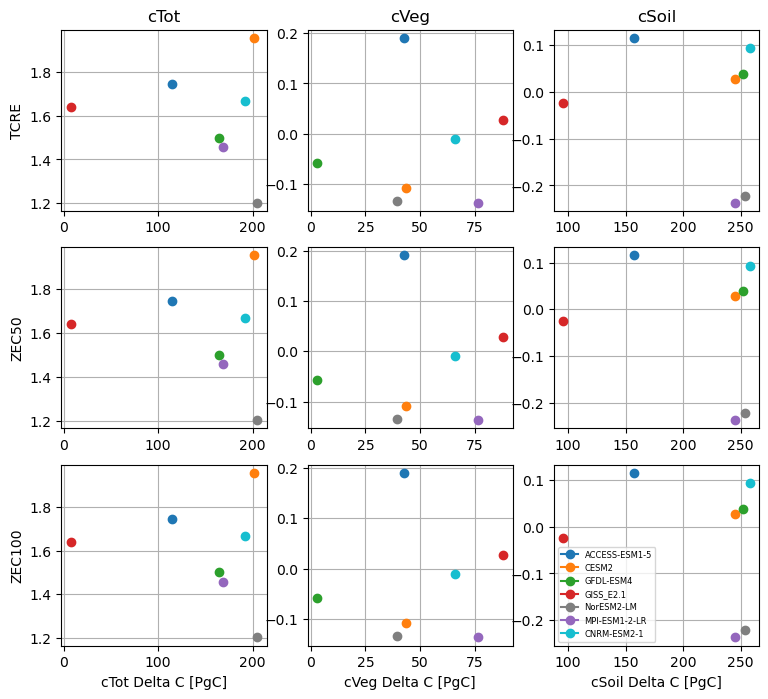

In [427]:
fig, axes = plt.subplots(3,3,figsize=(9, 8))
#axes=axes.flatten()

# rows are carbon variables, cTot, cVeg, cSoil
# columns are total change, % change
vlist = [2,1,0]
e=0

for m in range(len(modellist)):
    model=modellist[m]
    mcolor=modelcolors[m]

    tcre= esm_metrics_flat10['tcre'].values
    zec50=esm_metrics_flat10['zec50'].values
    zec100=esm_metrics_flat10['zec100'].values
    
    
    for vi in range(len(vlist)):
        v=vlist[vi]
        initC=np.mean(C_global_mat[0:9,m,0,0])
        nzC=np.mean(C_global_mat[90:109,m,0,0])
        deltaC=nzC-initC
        axes[vi,0].plot(deltaC,tcre[m],marker='o',label=model,color=mcolor)
        axes[vi,0].grid()
    
        initC=np.mean(C_global_mat[0:9,m,0,1])
        nzC=np.mean(C_global_mat[90:109,m,0,1])
        deltaC=nzC-initC
        axes[vi,1].plot(deltaC,zec50[m],marker='o',label=model,color=mcolor)
        axes[vi,1].grid()
    
        initC=np.mean(C_global_mat[0:9,m,0,2])
        nzC=np.mean(C_global_mat[90:109,m,0,2])
        deltaC=nzC-initC
        axes[vi,2].plot(deltaC,zec100[m],marker='o',label=model,color=mcolor)
        axes[vi,2].grid() 
    



axes[0,0].set_title('cTot')
axes[0,1].set_title('cVeg')
axes[0,2].set_title('cSoil')



axes[2,0].set_xlabel('cTot Delta C [PgC]')
axes[2,1].set_xlabel('cVeg Delta C [PgC]')
axes[2,2].set_xlabel('cSoil Delta C [PgC]')


axes[0,0].set_ylabel('TCRE')
axes[1,0].set_ylabel('ZEC50')
axes[2,0].set_ylabel('ZEC100')
#axes[3,0].set_ylabel(var +'DeltaC at 1000PgC [%]')

axes[2,2].legend(fontsize=6)

plt.savefig("figures/TCRE_ZEC_scatter.pdf", bbox_inches='tight')
plt.savefig("figures/TCRE_ZEC_scatter.jpg", bbox_inches='tight')


In [ ]:
### This is not working right becuase the cdr experiment for access has data problems

fig, axes = plt.subplots(3,4,figsize=(13, 8))
#axes=axes.flatten()

# rows are carbon variables, cTot, cVeg, cSoil
# columns are total change, % change
vlist = [2,1,0]

#e=0

for m in range(len(modellist)):
    model=modellist[m]
    mcolor=modelcolors[m]

    for vi in range(len(vlist)):
        v=vlist[vi]
      #  l=0
        for l in range(len(latlist)):
          #  initC=np.mean(C_global_mat[0:9,m,0,v])
            e=0
            timeseries=ds_C_global.sel(model=modellist[m], run=runlist[e], 
                                           var=varlist[v], latrange=latlist[l])
            initC=np.mean(timeseries.data[0:9])
            
          #  nzC=np.mean(C_global_mat[190:199,m,2,v])
            e=2
            timeseries=ds_C_global.sel(model=modellist[m], run=runlist[e], 
                                           var=varlist[v], latrange=latlist[l])
            
            nzC=np.mean(timeseries.data[190:199])
            axes[vi,l].plot(initC,(nzC-initC),marker='o',label=model,color=mcolor)
            axes[vi,l].grid()
    
#        initC=np.mean(C_troplat_mat[0:9,m,0,v])
#        nzC=np.mean(C_troplat_mat[190:199,m,2,v])
#        axes[vi,1].plot(initC,(nzC-initC),marker='o',label=model,color=mcolor)
#        axes[vi,1].grid()
#    
#        initC=np.mean(C_midlat_mat[0:9,m,0,v])
#        nzC=np.mean(C_midlat_mat[190:199,m,2,v])
#        axes[vi,2].plot(initC,(nzC-initC),marker='o',label=model,color=mcolor)
#        axes[vi,2].grid() 
#    
#        initC=np.mean(C_highlat_mat[0:9,m,0,v])
#        nzC=np.mean(C_highlat_mat[190:199,m,2,v])
#        axes[vi,3].plot(initC,(nzC-initC),marker='o',label=model,color=mcolor)
#        axes[vi,3].grid()


#axes[0,0].set_title('Global')
#axes[0,1].set_title('Tropical')
#axes[0,2].set_title('Mid Latitdes')
#axes[0,3].set_title('High Latitudes')

axes[0,0].set_title(latlist[0])
axes[0,1].set_title(latlist[1])
axes[0,2].set_title(latlist[2])
axes[0,3].set_title(latlist[3])


axes[2,0].set_xlabel('Initial C [PgC]')
axes[2,1].set_xlabel('Initial C [PgC]')
axes[2,2].set_xlabel('Initial C [PgC]')
axes[2,3].set_xlabel('Initial C [PgC]')

axes[0,0].set_ylabel(varlist[vlist[0]] +' DeltaC at cumNZ [PgC]')
axes[1,0].set_ylabel(varlist[vlist[1]] +' DeltaC at cumNZ [PgC]')
axes[2,0].set_ylabel(varlist[vlist[2]] +' DeltaC at cumNZ [PgC]')
#axes[3,0].set_ylabel(var +'DeltaC at 1000PgC [%]')

axes[2,3].legend(fontsize=6)

plt.savefig("figures/deltaCscatter_PgC_cumNZ.pdf", bbox_inches='tight')
plt.savefig("figures/deltaCscatter_PgC_cumNZ.jpg", bbox_inches='tight')


In [286]:
# example for one model and one experiment
# needs a loop to be broadcast to all runs
#m=0
#e=0
#var='cTot'

#- initialize
#C_global_mat= np.empty([350,len(modellist),len(runlist),len(varlist)])
#C_highlat_mat= np.empty([350,len(modellist),len(runlist),len(varlist)])
#C_troplat_mat= np.empty([350,len(modellist),len(runlist),len(varlist)])
#C_midlat_mat= np.empty([350,len(modellist),len(runlist),len(varlist)])


#for m in range(len(modellist)):
#for m in range(0):#len(['CESM2'])):#'GFDL-ESM4',  'GISS_E2.1',  'NorESM2-LM','MPI-ESM1-2-LR'])):
m=4
model=modellist[m]
print('loading model: ' +model)

#----loop over experiments----# 
#for e in range(0):#len(runlist)):
e=0
run = runlist_wc[e]
print('loading run: ' +run)


ds=data_dict[modellist[m] +'_' +runlist[e]]
ds_area = data_dict[modellist[m] +'_' +'areacella']
ds_landfrac = data_dict[modellist[m] +'_' +'landfrac']
#area = ds_area['areacella'].expand_dims(dim={'time': ds.time.size}, axis=0)
#landfrac=ds_landfrac['sftlf'].expand_dims(dim={'time': ds.time.size}, axis=0)

#area = ds_area['areacella']#.reindex_like(ds, method='nearest',tolerance=0.05)
area = ds_area['areacella'].reindex_like(ds, method='nearest',tolerance=0.05)
#area = area[:,-1]
landfrac=ds_landfrac['sftlf'].reindex_like(ds, method='nearest',tolerance=0.05)


if landfrac.max(dim=['lat','lon'])>1:
    landfrac=landfrac/100
    
landarea=area*landfrac

troplat=30
highlat=60



#----loop over variables----#
#for v in range(len(varlist)):
v=2
var=varlist[v]
#print('loading variable: ' +var)

data_var= weighted_temporal_mean(ds, var)

# total carbon on land. Becuase it is in units of carbon/area (kgC/m2), multiply by area
# our area variable is in m2
C_global =(((data_var*landarea)).sum(dim=['lat','lon']))
   # C_highlat=((data_var*landarea).where(ds.lat>=highlat)).sum(dim=['lat','lon'])
C_troplat=((data_var*landarea).where((ds.lat>=-troplat) & (ds.lat<=troplat))).sum(dim=['lat','lon'])
   # C_midlat=((data_var*landarea).where((ds.lat>=troplat) & (ds.lat<=highlat))).sum(dim=['lat','lon'])
    
   # C_global_mat[0:len(C_global),m,e,v]= C_global
   # C_highlat_mat[0:len(C_global),m,e,v]= C_highlat
   # C_troplat_mat[0:len(C_global),m,e,v]= C_troplat
   # C_midlat_mat[0:len(C_global),m,e,v]= C_midlat




## for per area variables need area weighting
#cTot_global = (((ds[var]*landarea)).sum(dim=['lat','lon']))/(landarea.sum(dim=['lat','lon']))
#cTot_highlat=((ds[var]*landarea).where(ds.lat>=highlat)).sum(dim=['lat','lon'])/(landarea.where(ds.lat>=highlat).sum(dim=['lat','lon']))
#cTot_troplat=((ds[var]*landarea).where((ds.lat>=-troplat) & (ds.lat<=troplat))).sum(dim=['lat','lon'])/(landarea.where((ds.lat>=-troplat) & (ds.lat<=troplat)).sum(dim=['lat','lon']))
#cTot_midlat=((ds[var]*landarea).where((ds.lat>=troplat) & (ds.lat<=highlat))).sum(dim=['lat','lon'])/(landarea.where((ds.lat>=troplat) & (ds.lat<=highlat)).sum(dim=['lat','lon']))


 #----merge all variables into one dataset----#
# if it's the first variable, then start a new datset, otherwise merge with existing
#if v ==0:
#    ds_cTot_global = cTot_global.copy()
#else:
#    #dsmerge_v=xr.merge([dsmerge_v, dsmerge_f])
#    ds_cTot_global = xr.merge([ds_cTot_global, cTot_global])

#dsmerge_v=xr.merge([dsmerge_v, dsmerge_f])

loading model: NorESM2-LM
loading run: *lat10


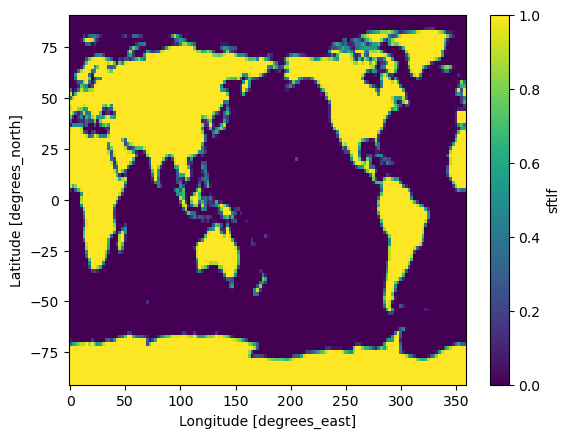

In [287]:
landfrac.plot()

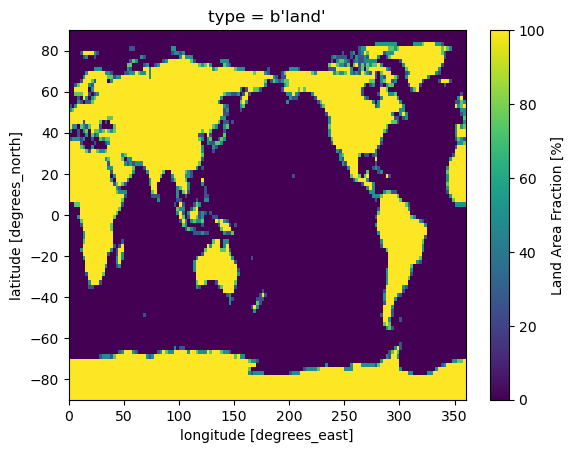

In [417]:
model='GISS_E2.1'

ds_area = data_dict[model +'_' +'areacella']
ds_landfrac = data_dict[model +'_' +'landfrac']

area_vec = ds_area['areacella'][:,-1]
area,lf = xr.broadcast(area_vec,ds_landfrac['sftlf'])

landarea=ds_area['areacella']*ds_landfrac['sftlf']

#landarea.plot()

ds_landfrac['sftlf'].plot()
#ds_area['areacella'].plot()

In [124]:
a=landarea.sum(dim=['lon']).values

c=ds[var].mean(dim=['time','lon']).values

zm=a*c

g=np.nansum(zm)/np.nansum(a)

print(g)

1.4866142e+16


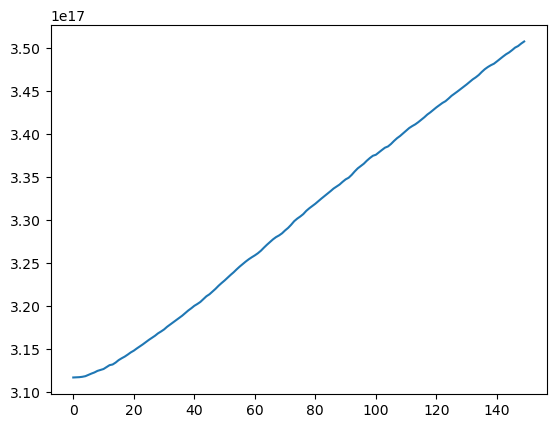

In [272]:
plt.plot(C_global)

#(((data_var)).sum(dim=['lat','lon'])).plot()

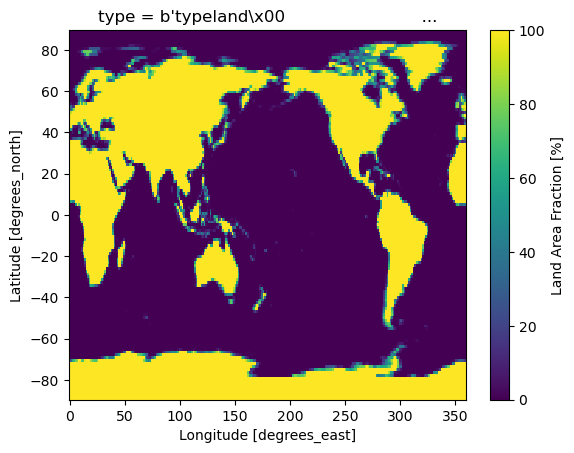

In [275]:
landfrac.plot()

(array([2.061163e+06, 8.687000e+03, 1.500000e+03, 6.000000e+02,
        7.500000e+02, 1.500000e+02, 0.000000e+00, 1.500000e+02,
        3.000000e+02, 3.000000e+02]),
 array([   0.        ,  354.40310059,  708.80620117, 1063.20930176,
        1417.61240234, 1772.01550293, 2126.41860352, 2480.8217041 ,
        2835.22480469, 3189.62790527, 3544.03100586]),
 <BarContainer object of 10 artists>)

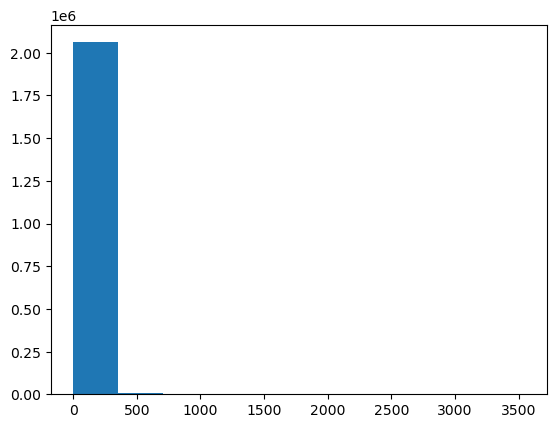

In [267]:
#area = ds_area['areacella'].squeeze().reindex_like(ds, method='nearest',tolerance=0.05)
#landfrac=ds_landfrac['sftlf']#.reindex_like(ds, method='nearest',tolerance=0.05)
#areaV=area[:,-1]
#landarea=areaV*landfrac

#data_var.mean(dim='time').plot()
(data_var).plot()

In [218]:
area[:,-1]

<xarray.DataArray 'areacella' (lat: 90)>
array([          nan, 3.2353262e+09, 5.3878303e+09, 7.5337702e+09,
       9.6705311e+09, 1.1795510e+10, 1.3906119e+10, 1.5999784e+10,
       1.8073956e+10, 2.0126110e+10, 2.2153740e+10, 2.4154380e+10,
       2.6125593e+10, 2.8064975e+10, 2.9970164e+10, 3.1838841e+10,
       3.3668725e+10, 3.5457589e+10, 3.7203255e+10, 3.8903591e+10,
       4.0556532e+10, 4.2160062e+10, 4.3712225e+10, 4.5211132e+10,
       4.6654956e+10, 4.8041935e+10, 4.9370386e+10, 5.0638684e+10,
       5.1845288e+10, 5.2988727e+10, 5.4067610e+10, 5.5080616e+10,
       5.6026513e+10, 5.6904155e+10, 5.7712468e+10, 5.8450465e+10,
       5.9117249e+10, 5.9712008e+10, 6.0234019e+10, 6.0682641e+10,
       6.1057331e+10, 6.1357634e+10, 6.1583184e+10, 6.1733700e+10,
       6.1809005e+10, 6.1809005e+10, 6.1733700e+10, 6.1583184e+10,
       6.1357634e+10, 6.1057331e+10, 6.0682641e+10, 6.0234019e+10,
       5.9712008e+10, 5.9117249e+10, 5.8450465e+10, 5.7712468e+10,
       5.6904155e+10, 5.6026513e+10, 5.5080616e+10, 5.4067610e+10,
       5.2988727e+10, 5.1845288e+10, 5.0638684e+10, 4.9370386e+10,
       4.8041935e+10, 4.6654956e+10, 4.5211132e+10, 4.3712225e+10,
       4.2160062e+10, 4.0556532e+10, 3.8903591e+10, 3.7203255e+10,
       3.5457589e+10, 3.3668725e+10, 3.1838841e+10, 2.9970164e+10,
       2.8064975e+10, 2.6125593e+10, 2.4154380e+10, 2.2153740e+10,
       2.0126110e+10, 1.8073956e+10, 1.5999784e+10, 1.3906119e+10,
       1.1795510e+10, 9.6705311e+09, 7.5337702e+09, 5.3878303e+09,
       3.2353262e+09,           nan], dtype=float32)
Coordinates:
  * lat      (lat) float32 -90.0 -87.0 -85.0 -83.0 -81.0 ... 83.0 85.0 87.0 90.0
    lon      float32 178.8
Attributes:
    standard_name:  cell_area
    long_name:      Grid-Cell Area for Atmospheric Variables
    comment:        For atmospheres with more than 1 mesh (e.g., staggered gr...
    units:          m2
    cell_methods:   area: sum
    history:        2018-04-19T13:42:46Z altered by CMOR: replaced missing va...

<Figure size 800x500 with 0 Axes>

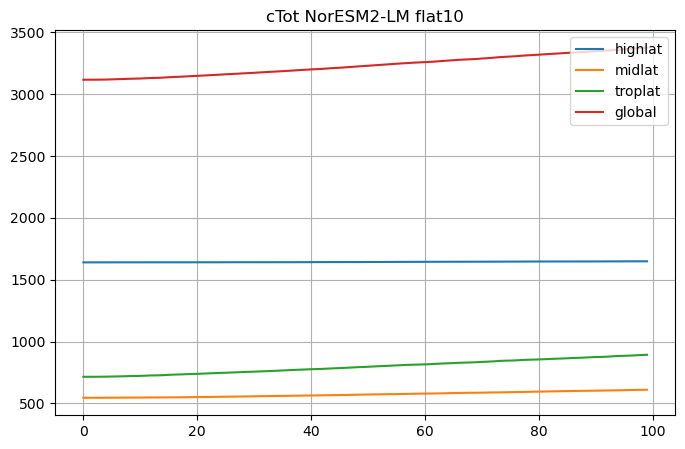

In [312]:
# [0:len(C_global),m,e,v]
fig = plt.figure(figsize=(8,5))

# [0:len(C_global),m,e,v]
e=0
v=2
m=4

#for m in range(len(modellist)):
#for m in range(len(['GFDL-ESM4',  'GISS_E2.1',  'NorESM2-LM','MPI-ESM1-2-LR'])):
 

model=modellist[m]

fig = plt.figure(figsize=(8,5))
plt.plot(C_highlat_mat[0:100,m,e,v],label='highlat')
plt.plot(C_midlat_mat[0:100,m,e,v],label='midlat')
plt.plot(C_troplat_mat[0:100,m,e,v],label='troplat')
plt.plot(C_global_mat[0:100,m,e,v],label='global')

plt.title(varlist[v] +' ' +modellist[m] +' ' +runlist[e])
#plt.ylabel(
plt.legend()
plt.grid()


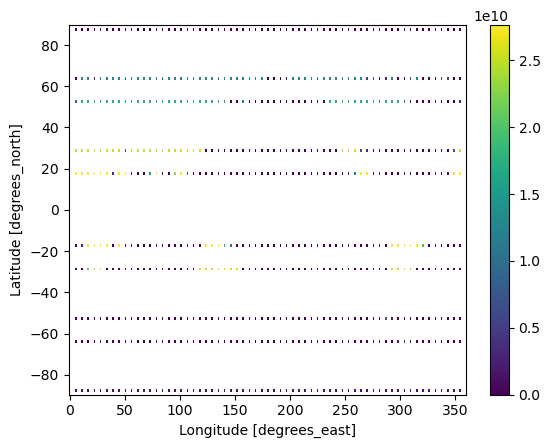

In [392]:
landarea.plot()


In [ ]:
dsften_cTot = (dst*landarea).sum(dim='lon').mean(dim='time')